# Notebook de análise exploratória dos dados (EDA)


O objetivo é desenvolver um **modelo preditivo**, com acuracidade mínima de 75%, e criar um sistema preditivo para auxiliar a equipe médica a prever o risco de desenvolver obesidade com base em fatores de estilo de vida.

**Dicionário de dados**:

- **Gender**: Gênero.
  - Valores: `Female` (Feminino), `Male` (Masculino)
- **Age**: Idade em anos.
  - Valores: numérico contínuo (ex: 14 anos)
- **Height**: Altura em metros.
  - Valores: numérico contínuo (ex.: 1.45–1.98 m)
- **Weight**: Peso em kgs.
  - Valores: numérico contínuo (ex.: 39–173 kg)
- **family_history**: Algum membro da família sofreu ou sofre de excesso de peso?
  - Valores: `yes` (há histórico), `no` (não há)
- **FAVC**: Você come alimentos altamente calóricos com frequência?
  - Valores: `yes` (sim), `no` (não).
- **FCVC**: Você costuma comer vegetais nas suas refeições?
  - Valores (escala 1–3): `1` (raramente), `2` (às vezes), `3` (sempre)
- **NCP**: Quantas refeições principais você faz diariamente?
  - Valores (escala 1–4): `1` (uma refeição), `2` (duas), `3` (três), `4` (quatro ou mais)
- **CAEC**: Você come alguma coisa entre as refeições?
  - Valores: `no` (não consome), `Sometimes` (às vezes), `Frequently` (frequentemente), `Always` (sempre)
- **SMOKE**: Você fuma?
  - Valores: `yes` (fuma), `no` (não fuma).
- **CH2O**: Quanta água você bebe diariamente?
  - Valores (escala 1–3): `1` (< 1 L/dia), `2` (1–2 L/dia), `3` (> 2 L/dia)
- **SCC**: Você monitora as calorias que ingere diariamente?
  - Valores: `yes` (sim), `no` (não)
- **FAF**: Com que frequência você pratica atividade física?
  - Valores (escala 0–3): `0` (nenhuma), `1` (~1–2×/sem), `2` (~3–4×/sem), `3` (5×/sem ou
    mais)}
- **TUE**: Quanto tempo você usa dispositivos tecnológicos como celular, videogame, televisão, computador e outros?
  - Valores (escala 0–2): `0` (~0–2 h/dia), `1` (~3–5 h/dia), `2` (> 5 h/dia)
- **CALC**: Com que frequência você bebe álcool?
  - Valores: `no` (não bebe), `Sometimes` (às vezes), `Frequently` (frequentemente), `Always` (sempre)
- **MTRANS**: Qual meio de transporte você costuma usar?
  - Valores: `Automobile` (carro), `Motorbike` (moto), `Bike` (bicicleta), `Public_Transportation` (transporte público), `Walking` (a pé).
- **Obesity** (coluna alvo): Nível de obesidade
  - Valores: `Insufficient_Weight` (abaixo do peso), `Normal_Weight` (peso normal),
    `Overweight_Level_I` (sobrepeso I), `Overweight_Level_II` (sobrepeso II), `Obesity_Type_I` (obesidade I), `Obesity_Type_II` (obesidade II),
    `Obesity_Type_III` (obesidade III)


## Importação das bibliotecas e configurações


In [1]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway
import seaborn as sns

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from tqdm import tqdm
from xgboost import XGBClassifier

In [ ]:
# Cores personalizadas
custom_palette = {
    "primary": "#F23064",
    "secondary": "#BF3B5E",
    "tertiary": "#FEFA01",
    "quartenary": "#FD7223",
    "quinary": "#7CFCBF",
    "senary": "#8A0858",
    "septanary": "#2408CD",
    "background": "#262626",
    "secondary_background": "#404040",
    "tertiary_background": "#8D8D8D",
    "text": "#FAFAFA",
}

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [custom_palette["senary"], custom_palette["primary"], custom_palette["tertiary"]],
    N=256,
)

In [ ]:
rc_config = {
    # Layout e fundo
    "figure.figsize": (20, 7),
    "figure.dpi": 100,
    "figure.facecolor": custom_palette["background"],
    "axes.facecolor": custom_palette["background"],
    "savefig.facecolor": custom_palette["background"],
    # Eixos e cores
    "axes.edgecolor": custom_palette["text"],
    "axes.labelcolor": custom_palette["text"],
    "axes.titlecolor": custom_palette["text"],
    "axes.titleweight": "bold",
    "axes.labelpad": 15,
    "axes.titlepad": 20,
    "axes.spines.top": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
    "patch.edgecolor": "none",
    "grid.color": custom_palette["secondary_background"],
    "grid.linestyle": "--",
    # Texto e fonte
    "text.color": custom_palette["text"],
    "xtick.color": custom_palette["tertiary_background"],
    "ytick.color": custom_palette["tertiary_background"],
    "font.family": "sans-serif",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    # Legenda
    "legend.facecolor": custom_palette["secondary_background"],
    "legend.edgecolor": custom_palette["text"],
}

plt.rcParams.update(rc_config)
sns.set_theme(style="darkgrid", rc=rc_config)
sns.set_palette(sns.color_palette(list(custom_palette.values())[0:7]))

In [ ]:
# configurar caminhos dos dados
data_file_name = "Obesity.csv"
dict_file_name = "data_dictionary.json"
raw_data_dir = "../data/raw"

# Machine Learning
seed = 42
test_size = 0.2
grid_search_cv_folds = 5

In [ ]:
# alvo
target_column = "obesity"
target_order = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Overweight_Level_II",
    "Obesity_Type_I",
    "Obesity_Type_II",
    "Obesity_Type_III",
]

# quantitativa
discrete_features = ["fcvc", "ncp", "ch2o", "faf", "tue"]
continuous_features = ["age", "height", "weight", "bmi"]
numeric_features = discrete_features + continuous_features

# qualitativa
nominal_features = ["gender", "family_history", "favc", "mtrans", "smoke", "scc"]
ordinal_features = ["caec", "calc"]
ordinal_variables_order = ["no", "Sometimes", "Frequently", "Always"]

categorical_features = nominal_features + ordinal_features

## Aquisição dos dados


In [ ]:
# carregando o dataset
df = pd.read_csv(f"{raw_data_dir}/{data_file_name}")
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
# informações gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

As colunas `fcvc`, `ncp`, `ch2o`, `faf`, `tue` devem ser arrendondadas para números inteiros.


In [ ]:
print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas")

O dataset tem 2111 linhas e 17 colunas


## Tratamento dos dados


In [ ]:
# renomear colunas para minúsculas
df.columns = [col.lower() for col in df.columns]

In [ ]:
# conferindo se há valores nulos
df.isna().sum()

gender            0
age               0
height            0
weight            0
family_history    0
favc              0
fcvc              0
ncp               0
caec              0
smoke             0
ch2o              0
scc               0
faf               0
tue               0
calc              0
mtrans            0
obesity           0
dtype: int64

O dataset não possui dados nulos.


In [ ]:
# conferindo se há valores duplicados
df.duplicated().sum()

np.int64(24)

In [ ]:
# conferindo quais são os valores duplicados
df[df.duplicated()]

,gender,age,height,weight,family_history,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,obesity
98,Female,21.0,1.52,42.0,no,no,3.0,1.0,Frequently,no,1.0,no,0.0,0.0,Sometimes,Public_Transportation,Insufficient_Weight
106,Female,25.0,1.57,55.0,no,yes,2.0,1.0,Sometimes,no,2.0,no,2.0,0.0,Sometimes,Public_Transportation,Normal_Weight
174,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
179,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
184,Male,21.0,1.62,70.0,no,yes,2.0,1.0,no,no,3.0,no,1.0,0.0,Sometimes,Public_Transportation,Overweight_Level_I
209,Female,22.0,1.69,65.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Sometimes,Public_Transportation,Normal_Weight
309,Female,16.0,1.66,58.0,no,no,2.0,1.0,Sometimes,no,1.0,no,0.0,1.0,no,Walking,Normal_Weight
460,Female,18.0,1.62,55.0,yes,yes,2.0,3.0,Frequently,no,1.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight
467,Male,22.0,1.74,75.0,yes,yes,3.0,3.0,Frequently,no,1.0,no,1.0,0.0,no,Automobile,Normal_Weight
496,Male,18.0,1.72,53.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,2.0,Sometimes,Public_Transportation,Insufficient_Weight


In [ ]:
# removendo valores duplicados
df = df.drop_duplicates().reset_index(drop=True)

Como o número total de dados duplicados é pequeno, podemos removê-los para não adicionar um peso indevido nesses 24 padrões específicos.


In [ ]:
# converter variáveis numéricas discretas para int
for col in discrete_features:
    if col in df.columns:
        df[col] = df[col].round().astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2087 entries, 0 to 2086
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          2087 non-null   object 
 1   age             2087 non-null   float64
 2   height          2087 non-null   float64
 3   weight          2087 non-null   float64
 4   family_history  2087 non-null   object 
 5   favc            2087 non-null   object 
 6   fcvc            2087 non-null   int64  
 7   ncp             2087 non-null   int64  
 8   caec            2087 non-null   object 
 9   smoke           2087 non-null   object 
 10  ch2o            2087 non-null   int64  
 11  scc             2087 non-null   object 
 12  faf             2087 non-null   int64  
 13  tue             2087 non-null   int64  
 14  calc            2087 non-null   object 
 15  mtrans          2087 non-null   object 
 16  obesity         2087 non-null   object 
dtypes: float64(3), int64(5), object(9

## Engenharia de atributos


Calcular o **IMC** (Índice de Massa Corporal ou _Body Mass Index_, em inglês), que é a métrica global usada para classificar a obesidade. Segundo a Organização Mundial da Saúde, a classificação do IMC em adultos é a seguinte:

| **IMC**     | **Classificação**  |
| ----------- | ------------------ |
| < 18,5      | Magreza            |
| 18,5 a 24,9 | Eutrofia           |
| 25 a 29,9   | Pré-obesidade      |
| 30 a 34,9   | Obesidade grau I   |
| 35 a 39,9   | Obesidade grau II  |
| ≥ 40        | Obesidade grau III |

**Fonte:** WORLD HEALTH ORGANIZATION. _Obesity: preventing and managing the global epidemic._ Geneva: WHO, 1997.


Sua fórmula é:

$IMC = \frac{peso (kg)}{altura (m) ^2}$


In [ ]:
# certificando que não existe altura zero (para evitar divisão por zero)
df = df[df["height"] > 0]

In [ ]:
# adicionando a coluna de IMC
df["bmi"] = df["weight"] / (df["height"] ** 2)
df[["obesity", "bmi"]].head()

,obesity,bmi
0,Normal_Weight,24.386526
1,Normal_Weight,24.238227
2,Normal_Weight,23.765432
3,Overweight_Level_I,26.851852
4,Overweight_Level_II,28.342381


## Análise univariada


### Qualitativa


In [ ]:
# variável alvo
df[target_column].value_counts(normalize=True)

obesity
Obesity_Type_I         0.168184
Obesity_Type_III       0.155247
Obesity_Type_II        0.142310
Overweight_Level_II    0.138955
Normal_Weight          0.135122
Overweight_Level_I     0.132247
Insufficient_Weight    0.127935
Name: proportion, dtype: float64

A variável alvo está bem balanceada. Não será preciso usar técnicas de reamostragem, mas é preciso transformá-la em numérica (LabelEncoder).

Como precisamos classificar um indivíduo pelo seu peso, o ideal será utilizar um **modelo de classificação**.


In [ ]:
# variáveis qualitativas
for col in categorical_features:
    print(f"--- Coluna: {col} ---")
    print(df[col].value_counts())
    print("\n")

--- Coluna: gender ---
gender
Male      1052
Female    1035
Name: count, dtype: int64


--- Coluna: family_history ---
family_history
yes    1722
no      365
Name: count, dtype: int64


--- Coluna: favc ---
favc
yes    1844
no      243
Name: count, dtype: int64


--- Coluna: mtrans ---
mtrans
Public_Transportation    1558
Automobile                456
Walking                    55
Motorbike                  11
Bike                        7
Name: count, dtype: int64


--- Coluna: smoke ---
smoke
no     2043
yes      44
Name: count, dtype: int64


--- Coluna: scc ---
scc
no     1991
yes      96
Name: count, dtype: int64


--- Coluna: caec ---
caec
Sometimes     1761
Frequently     236
Always          53
no              37
Name: count, dtype: int64


--- Coluna: calc ---
calc
Sometimes     1380
no             636
Frequently      70
Always           1
Name: count, dtype: int64




As colunas `gender`, `family_history`, `favc`, `smoke`, `scc` e `mtrans` são **qualitativas nominais** (sem ordem -> usar OneHotEncoder), enquanto `caec` e `calc` são **qualitativas ordinais** (com ordem -> usar OrdinalEncoder).

Além disso, `smoke` e `scc` estão desbalanceadas.


### Quantitativa


In [ ]:
# variáveis quantitativas
df.describe()

,age,height,weight,fcvc,ncp,ch2o,faf,tue,bmi
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,24.353090,1.702674,86.858730,2.425970,2.703402,2.011500,1.009104,0.669861,29.765758
std,6.368801,0.093186,26.190847,0.585177,0.797108,0.685322,0.898712,0.673970,8.024934
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.998685
25%,19.915937,1.630178,66.000000,2.000000,3.000000,2.000000,0.000000,0.000000,24.368897
50%,22.847618,1.701584,83.101100,2.000000,3.000000,2.000000,1.000000,1.000000,28.896224
75%,26.000000,1.769491,108.015907,3.000000,3.000000,2.000000,2.000000,1.000000,36.095538
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000,50.811753


Não tem nenhum número negativo ou muito fora do esperado nas variáveis quantitativas. As variáveis `age`, `height`, `weight` e `bmi` são **quantitativas contínuas**, enquanto o restante são **quantitativas discretas**. Além disso, todas têm unidades de medidas diferentes, então seria melhor passar todas para a mesma escala.


## Análise multivariada


### Qualitativa


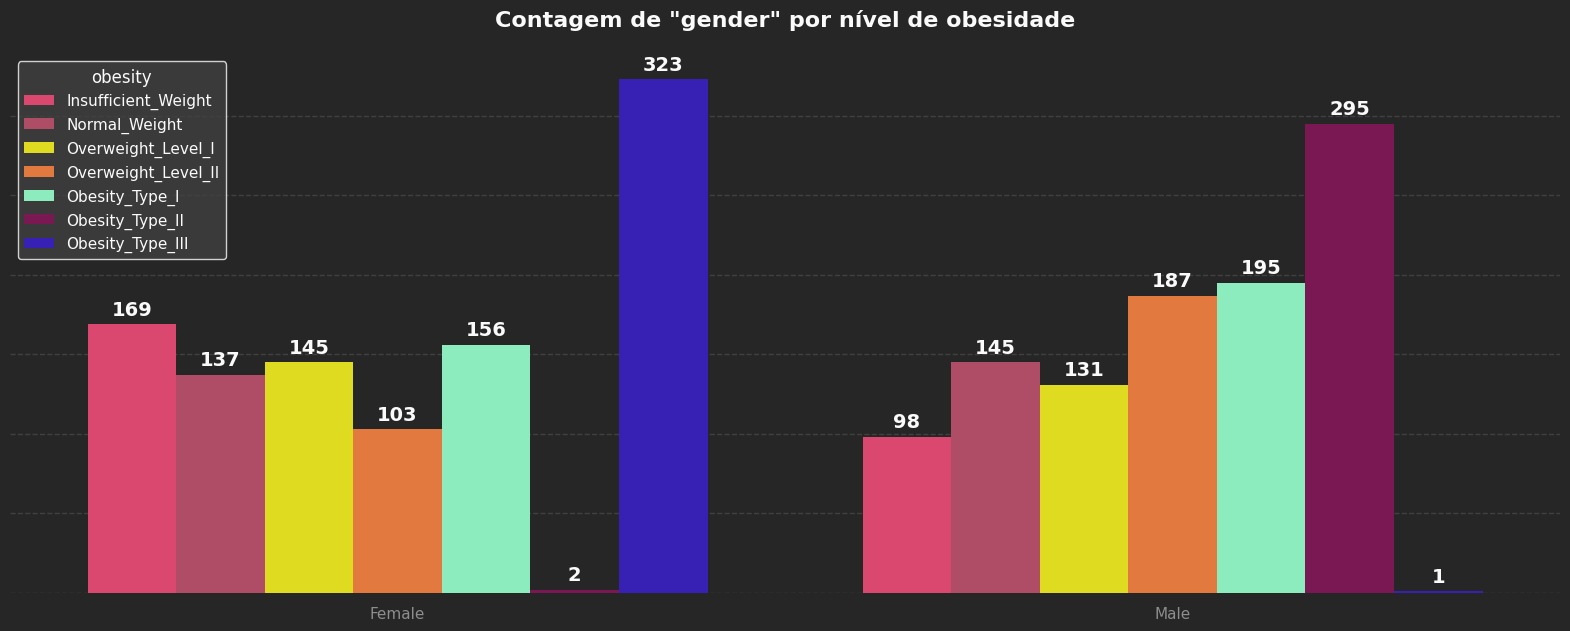

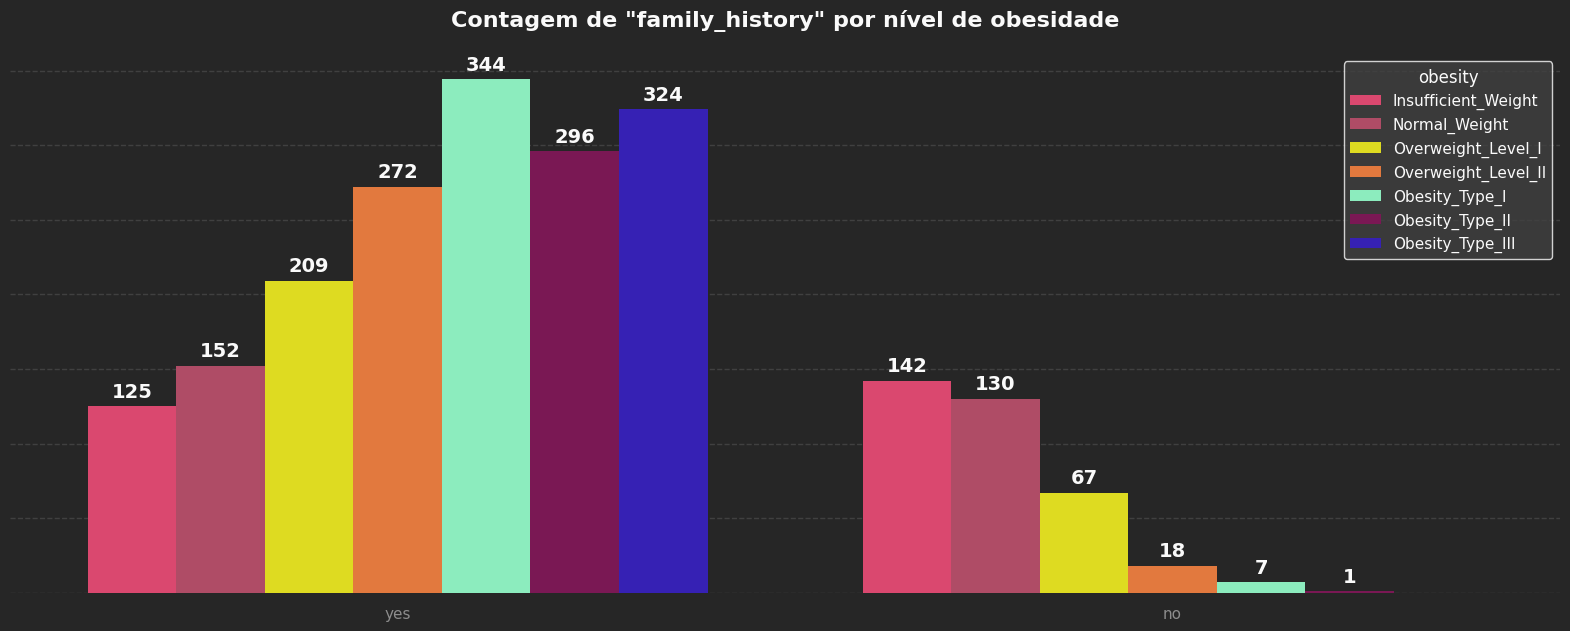

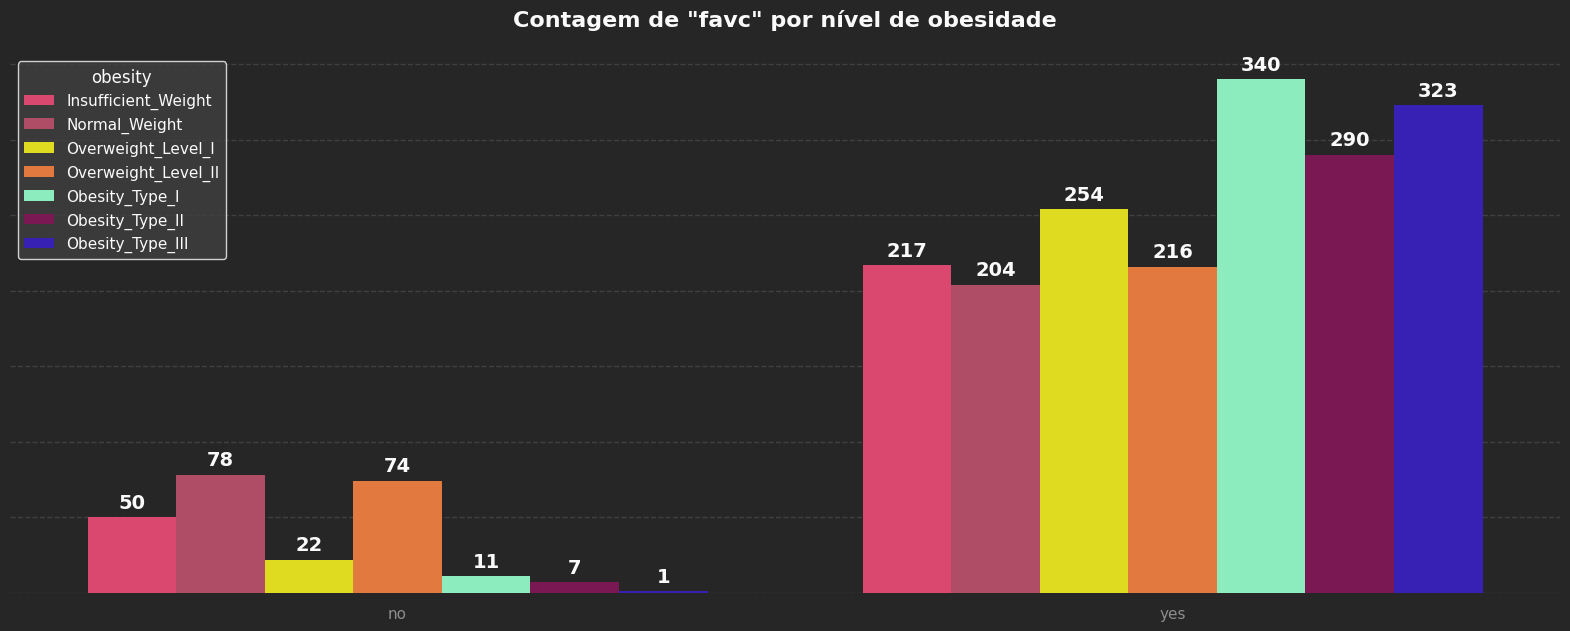

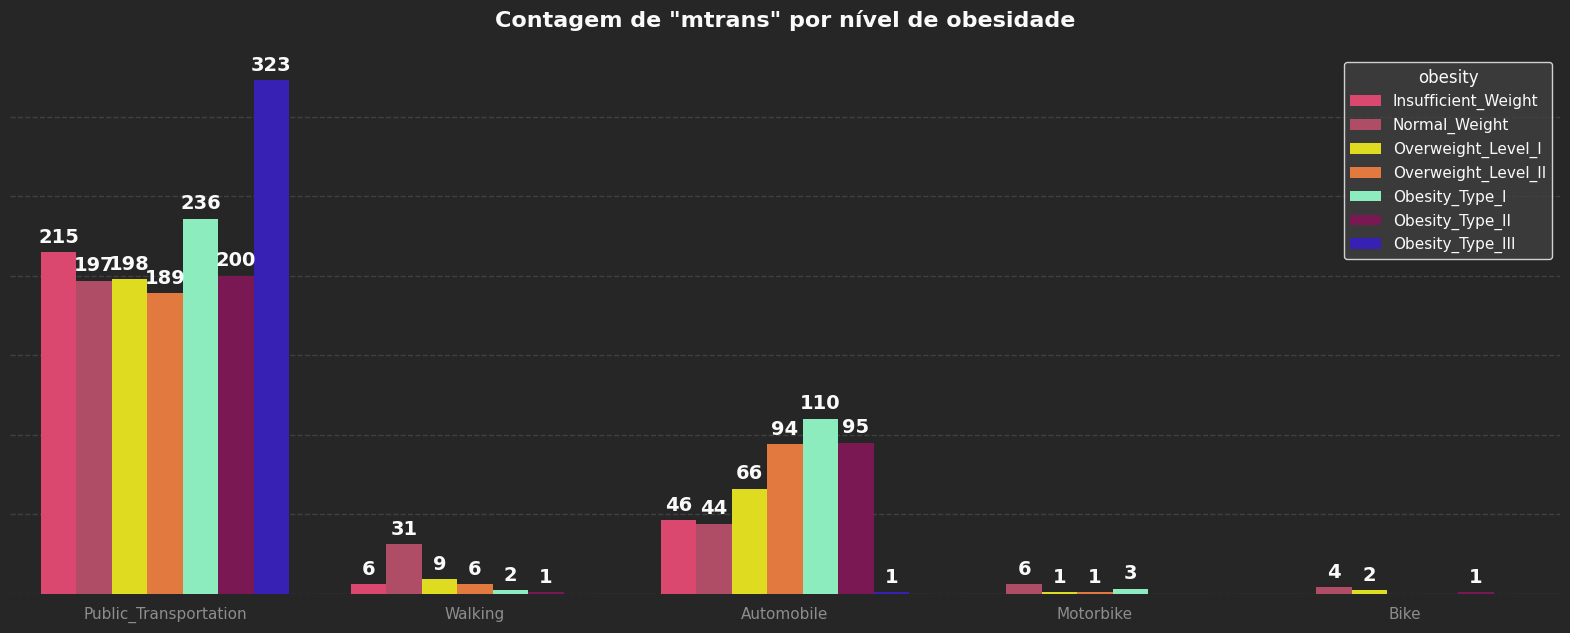

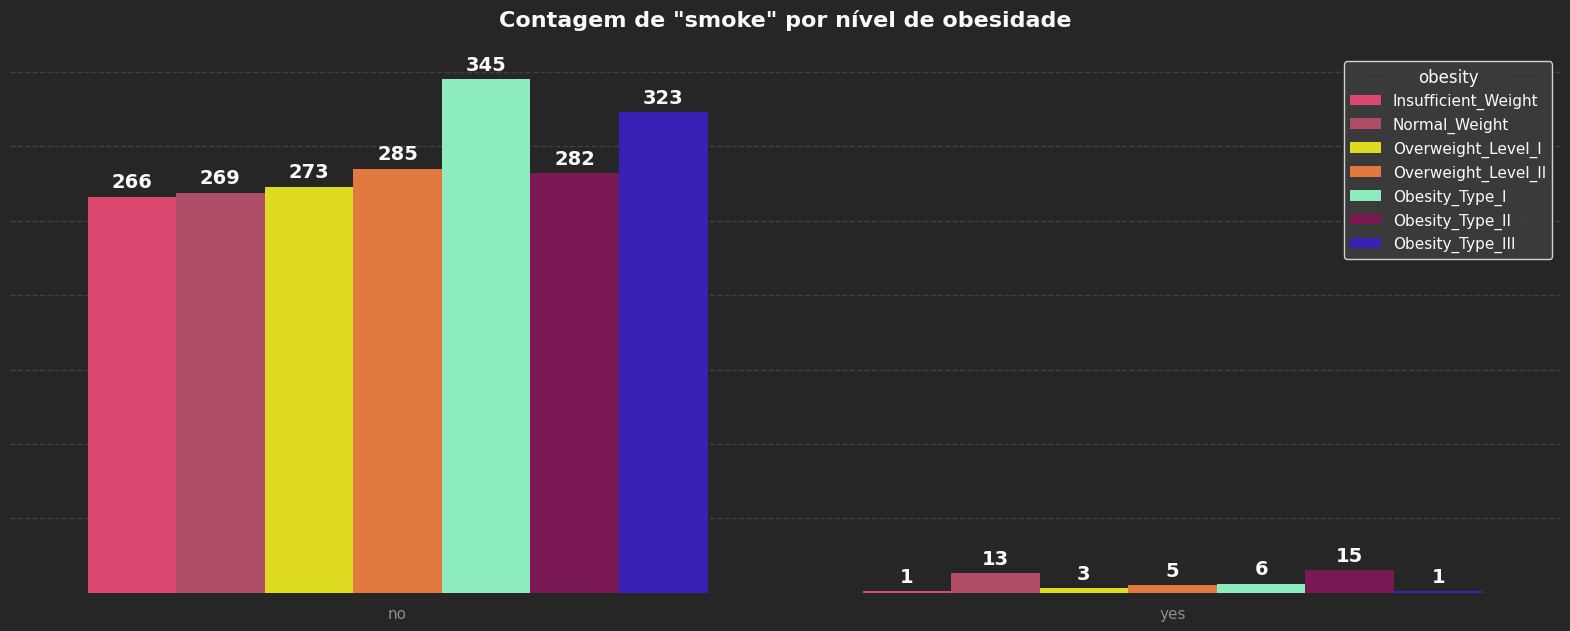

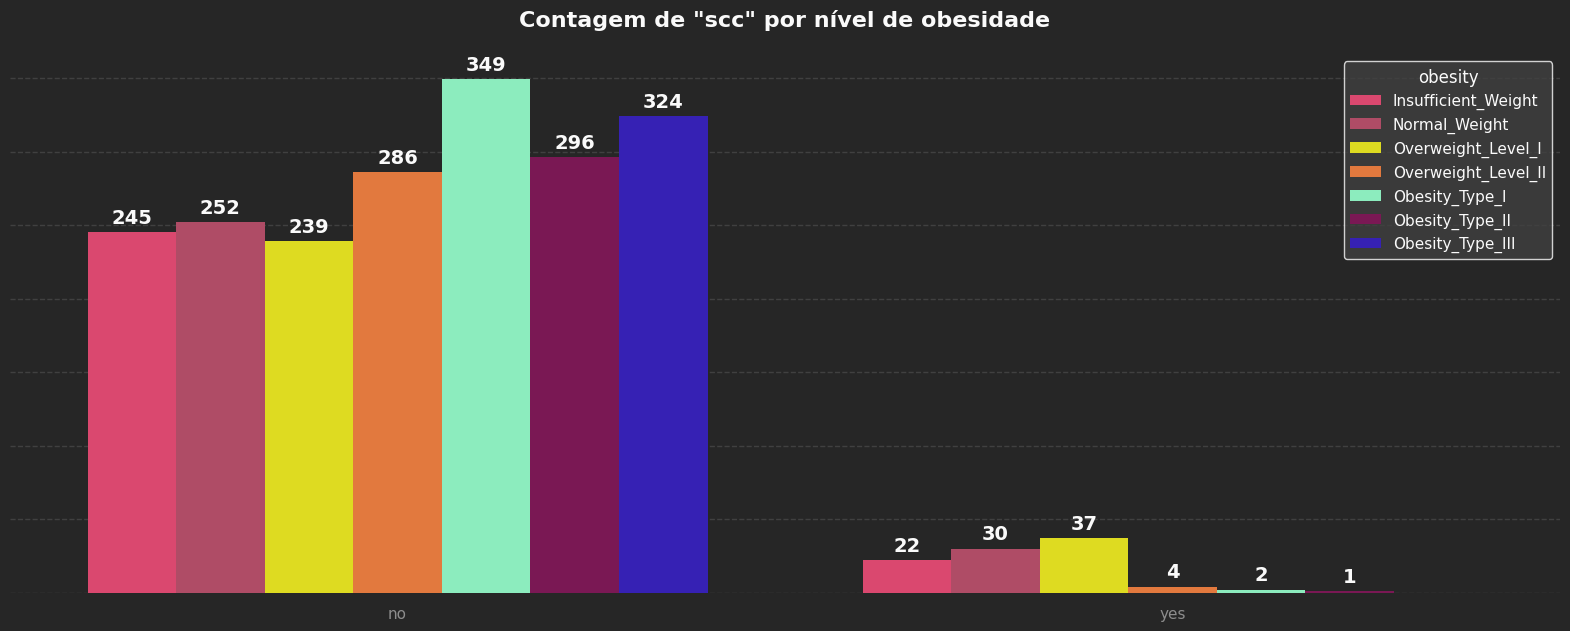

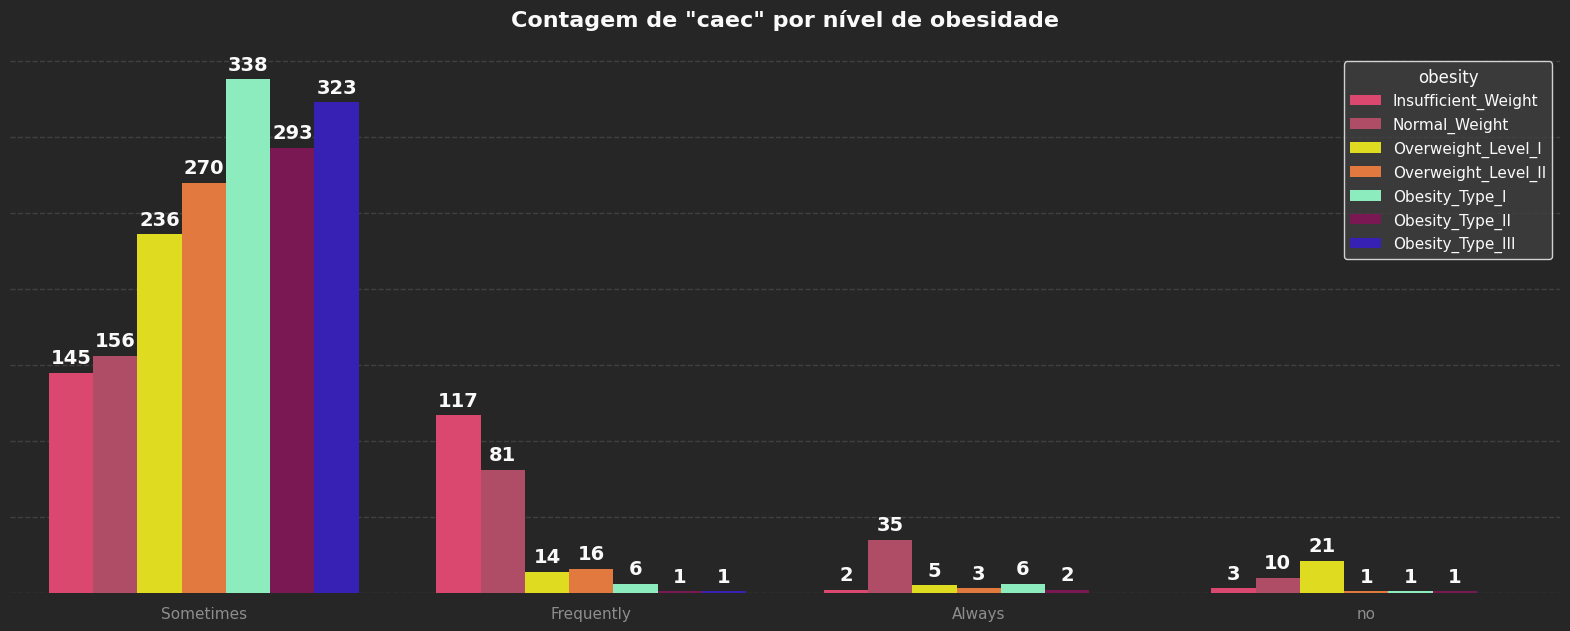

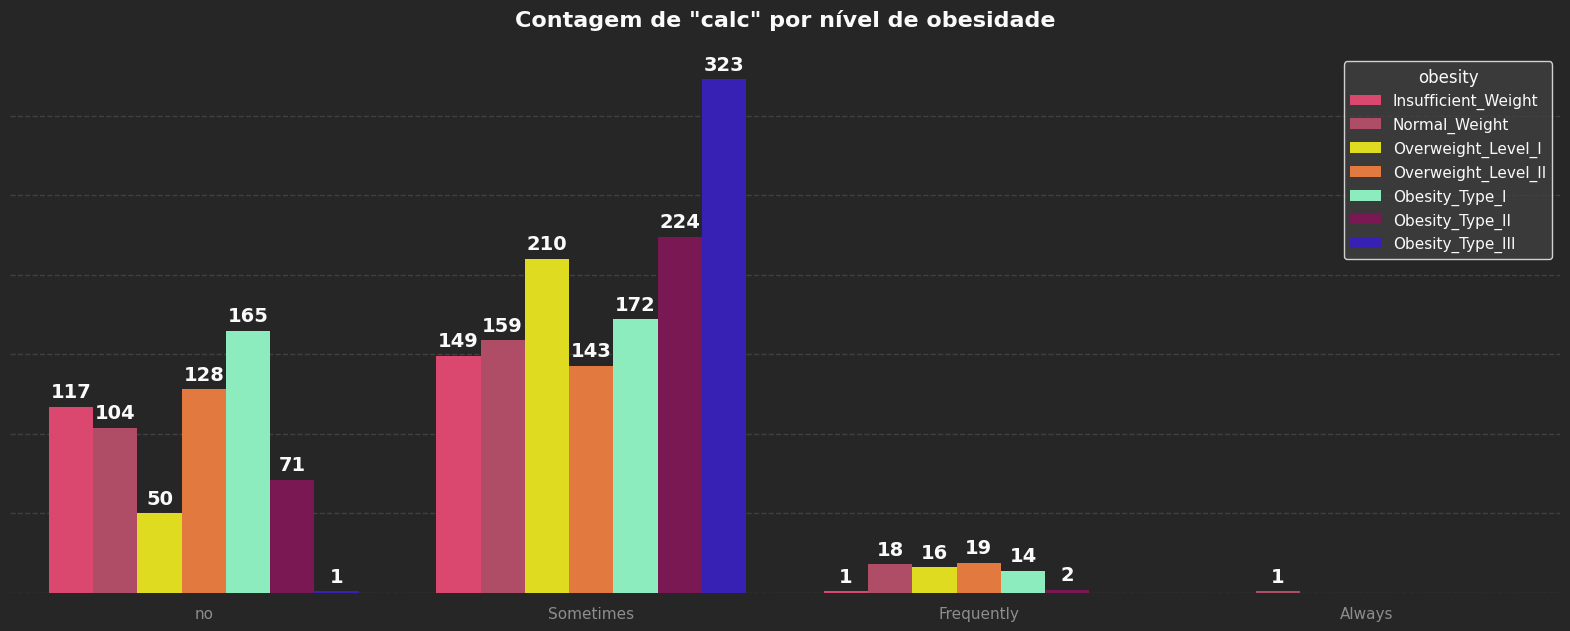

In [ ]:
for feature in categorical_features:
    ax = sns.countplot(df, x=feature, hue=target_column, hue_order=target_order)
    ax.set_title(f'Contagem de "{feature}" por nível de obesidade')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_yticklabels([])
    for container in ax.containers:
        ax.bar_label(
            container,
            fmt="%d",
            label_type="edge",
            color=custom_palette["text"],
            padding=4,
            fontsize=14,
            fontweight="bold",
        )
    plt.show()

Nesses dados, grande parte das pessoas com obesidade grau 3 são do gênero feminino, tem histórico de obesidade na família, tende a beber álcool algumas vezes e usa o meio de transporte público.


### Quantitativa


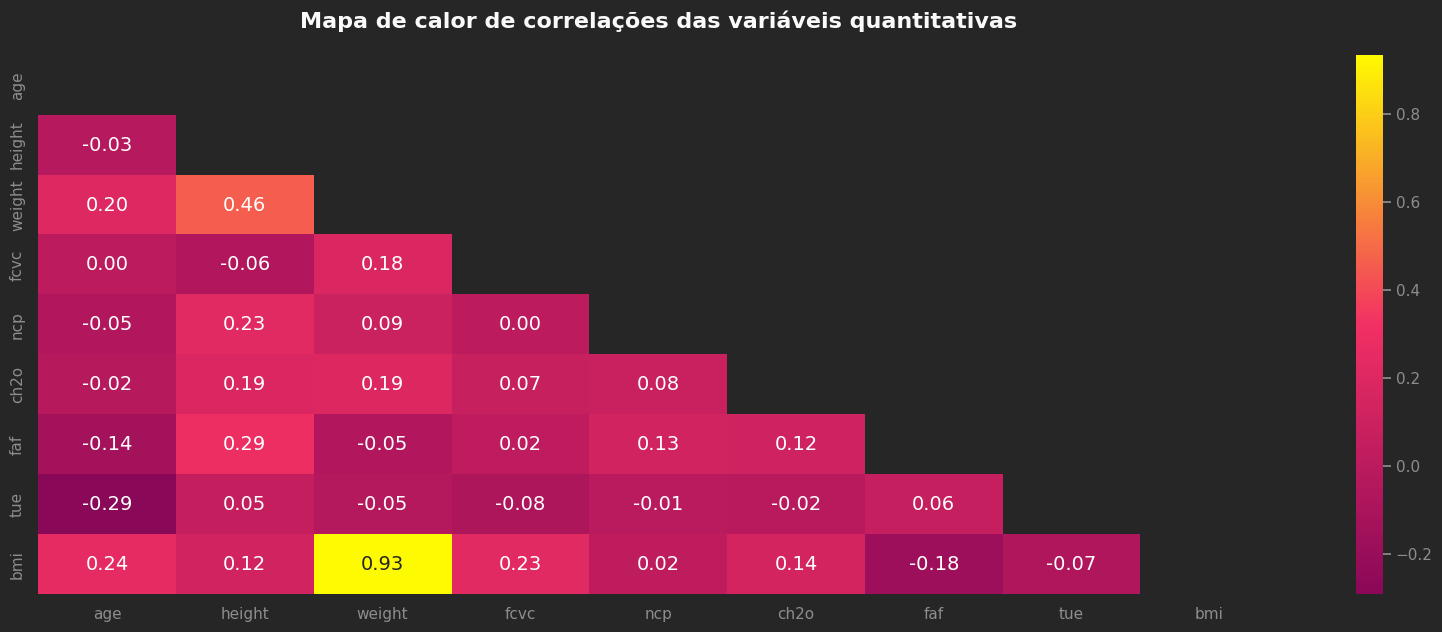

In [ ]:
# mapa de calor de correlação das variáveis quantitativas
corr = df.corr(numeric_only=True)

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=custom_cmap)
plt.title("Mapa de calor de correlações das variáveis quantitativas")
plt.grid(False)
plt.show()

- **Correlação positiva** entre `weight` e `height`, ou seja, quanto maior a altura, maior o peso da pessoa.
- **Correlação negativa** entre `tue` e `age`, ou seja, pessoas mais velhas usam dispositivos tecnológicos por menos tempo.

Há multicolinearidade entre `weight` e `bmi`. Portanto, incluir juntos como features em um modelo linear pode gerar redundância de informação e instabilidade nos coeficientes.


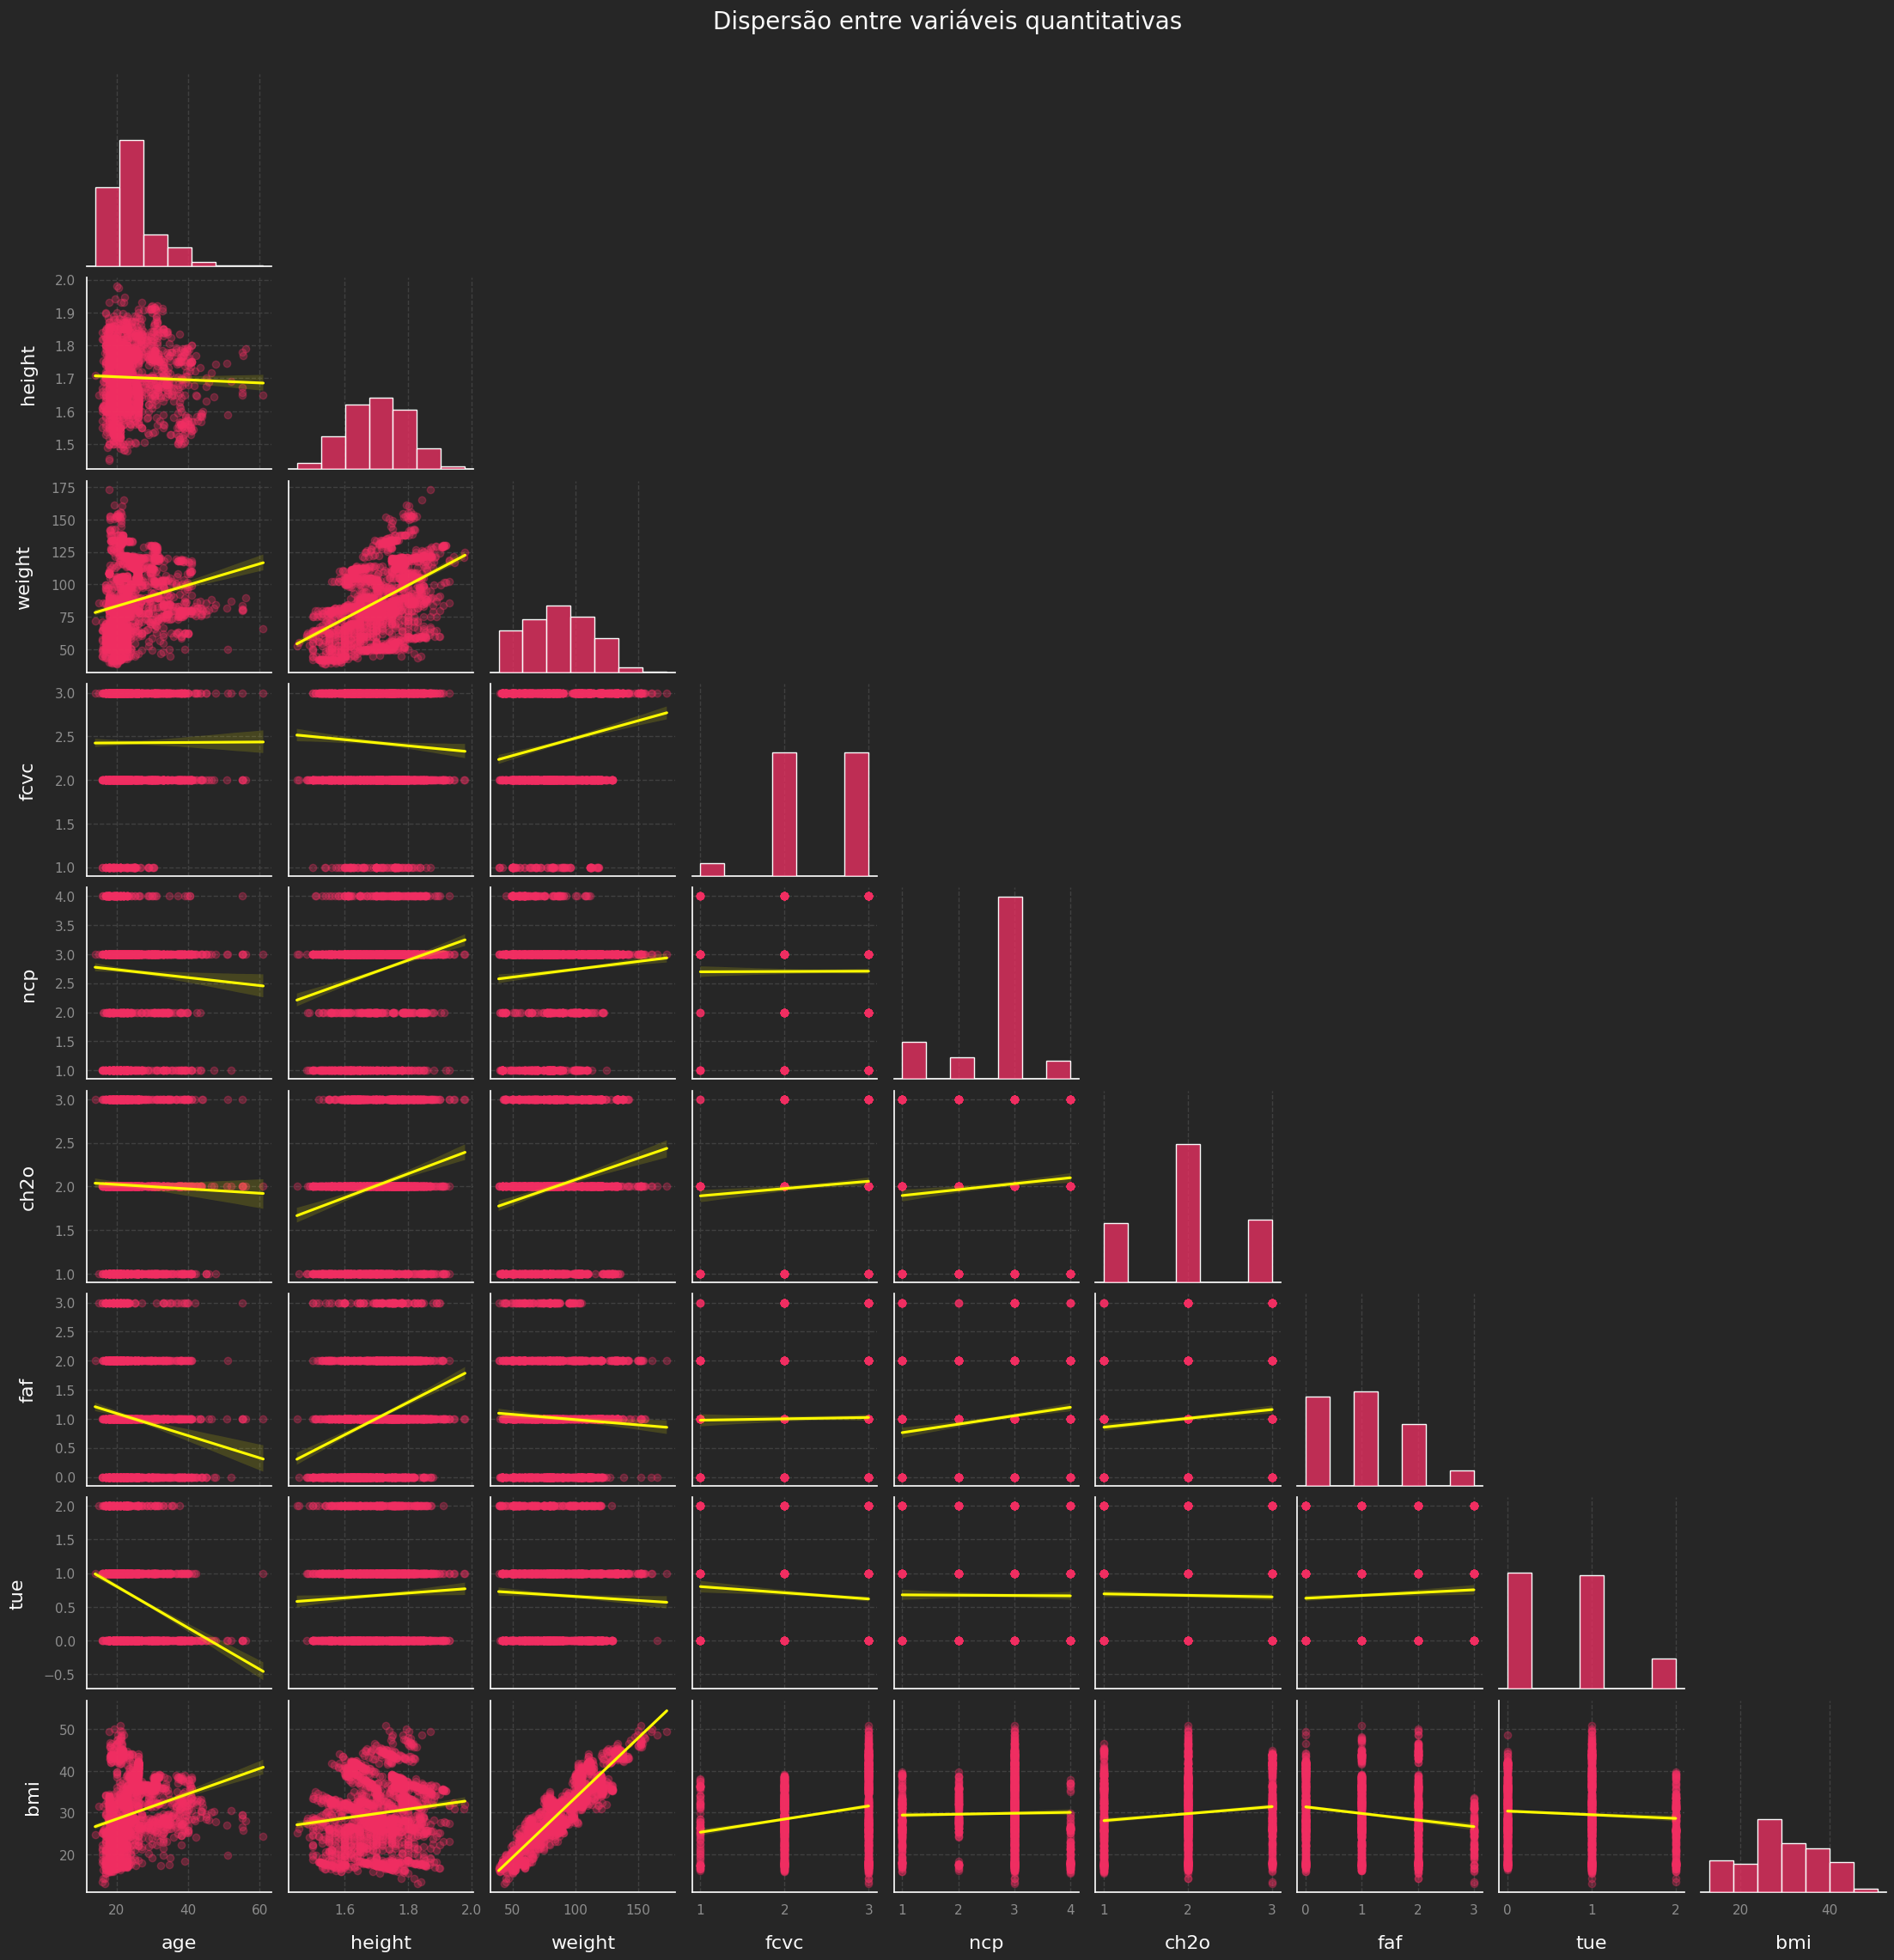

In [ ]:
# gráfico de dispersão entre variáveis quantitativas
ax = sns.pairplot(
    df,
    corner=True,
    kind="reg",
    plot_kws={
        "line_kws": {"color": custom_palette["tertiary"]},
        "scatter_kws": {"alpha": 0.3},
    },
    diag_kws={"bins": 7, "edgecolor": custom_palette["text"]},
)

ax.figure.suptitle(
    "Dispersão entre variáveis quantitativas",
    y=1.02,
    fontsize=20,
    color=custom_palette["text"],
)
plt.show()

- A coluna `height` tem pequenas correlações positivas com quase tudo. Isso sugere que pessoas mais altas, em geral, comem mais, bebem mais água e são um pouco mais ativas.
- A grande maioria das pessoas relata fazer 3 refeições por dia.


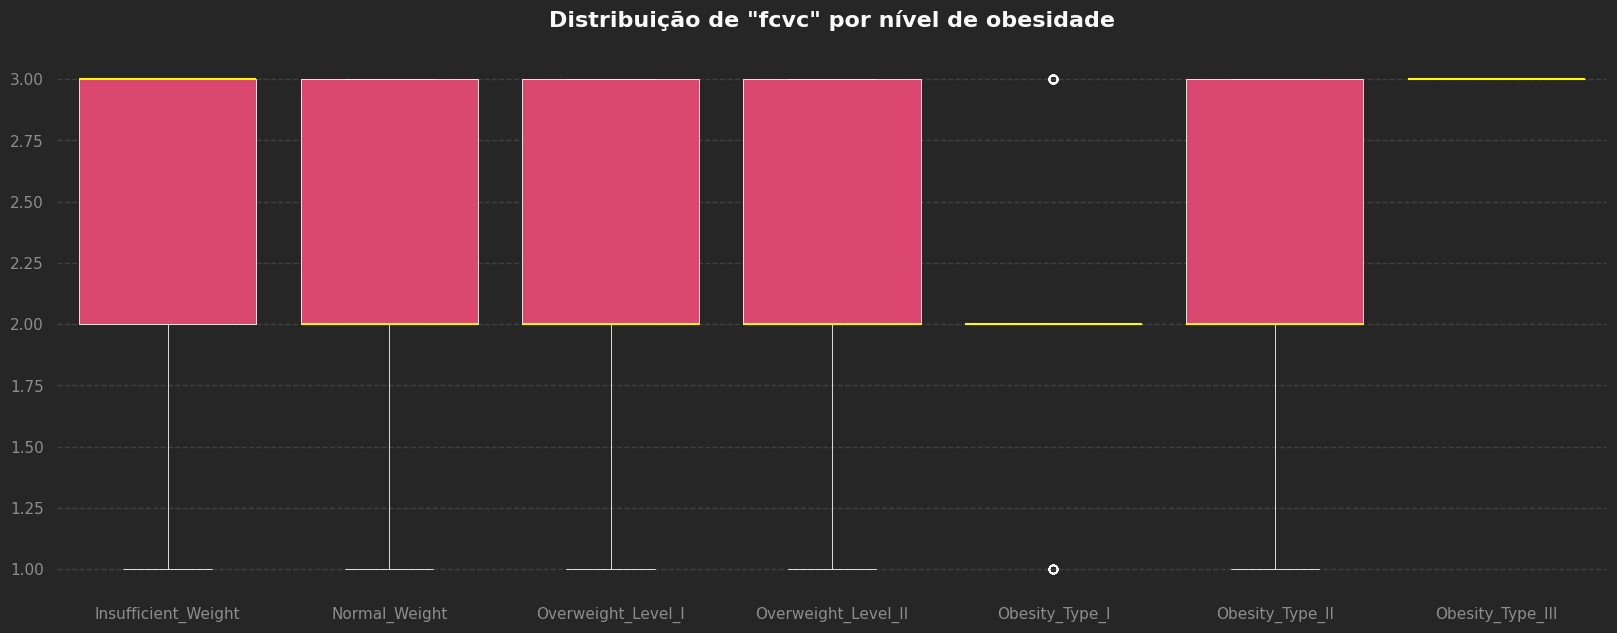

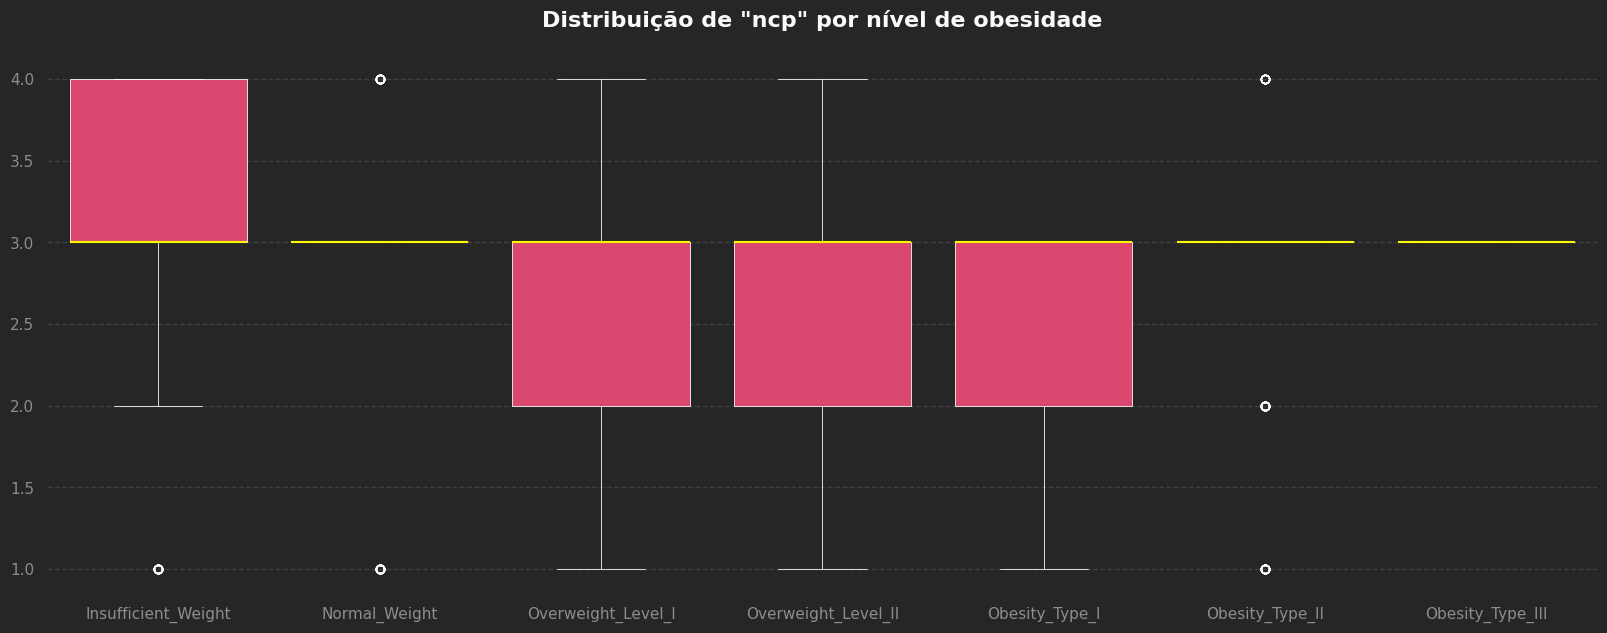

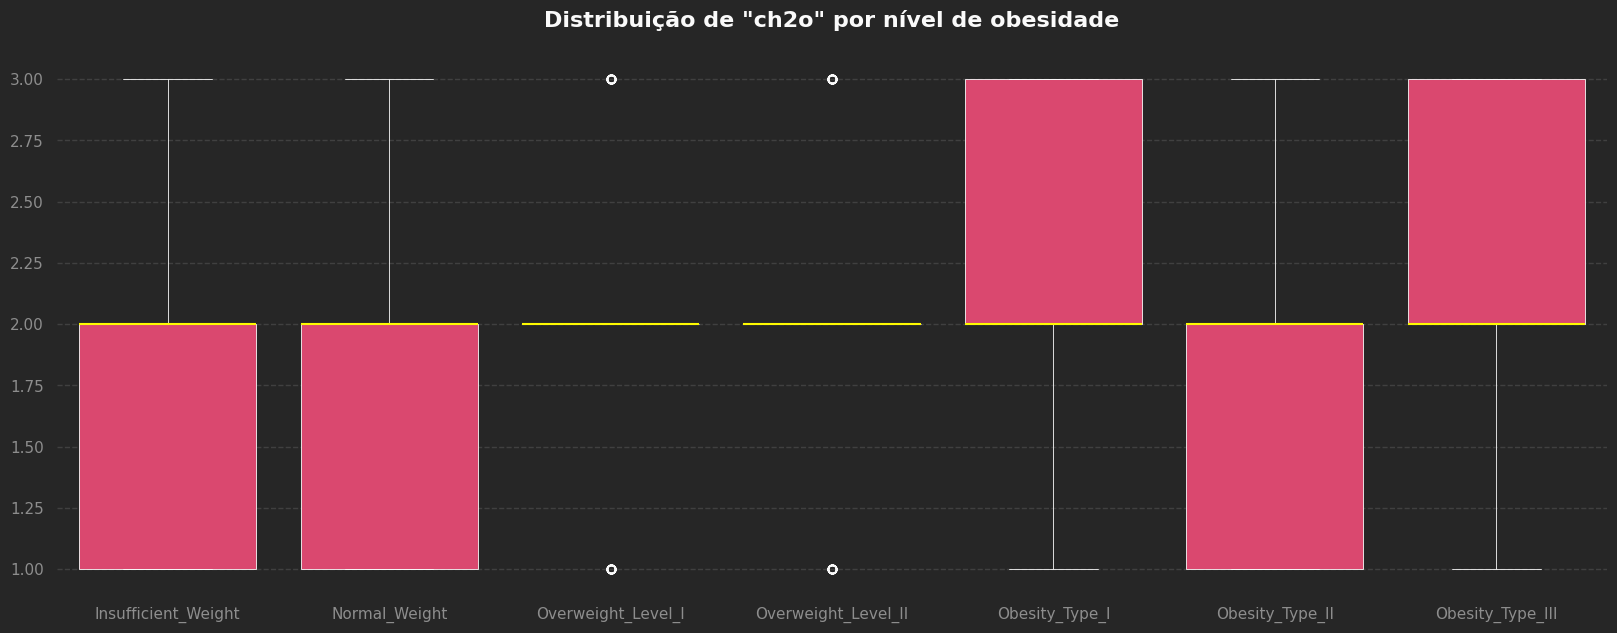

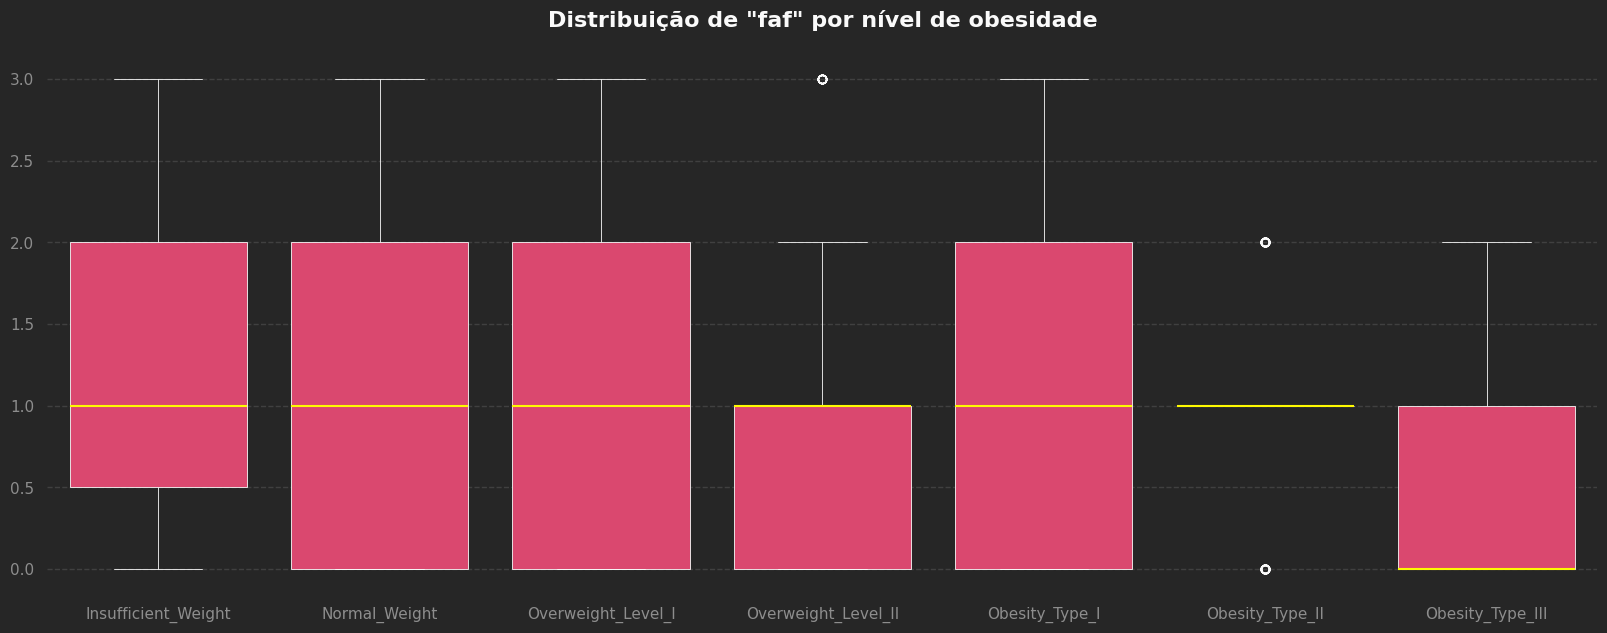

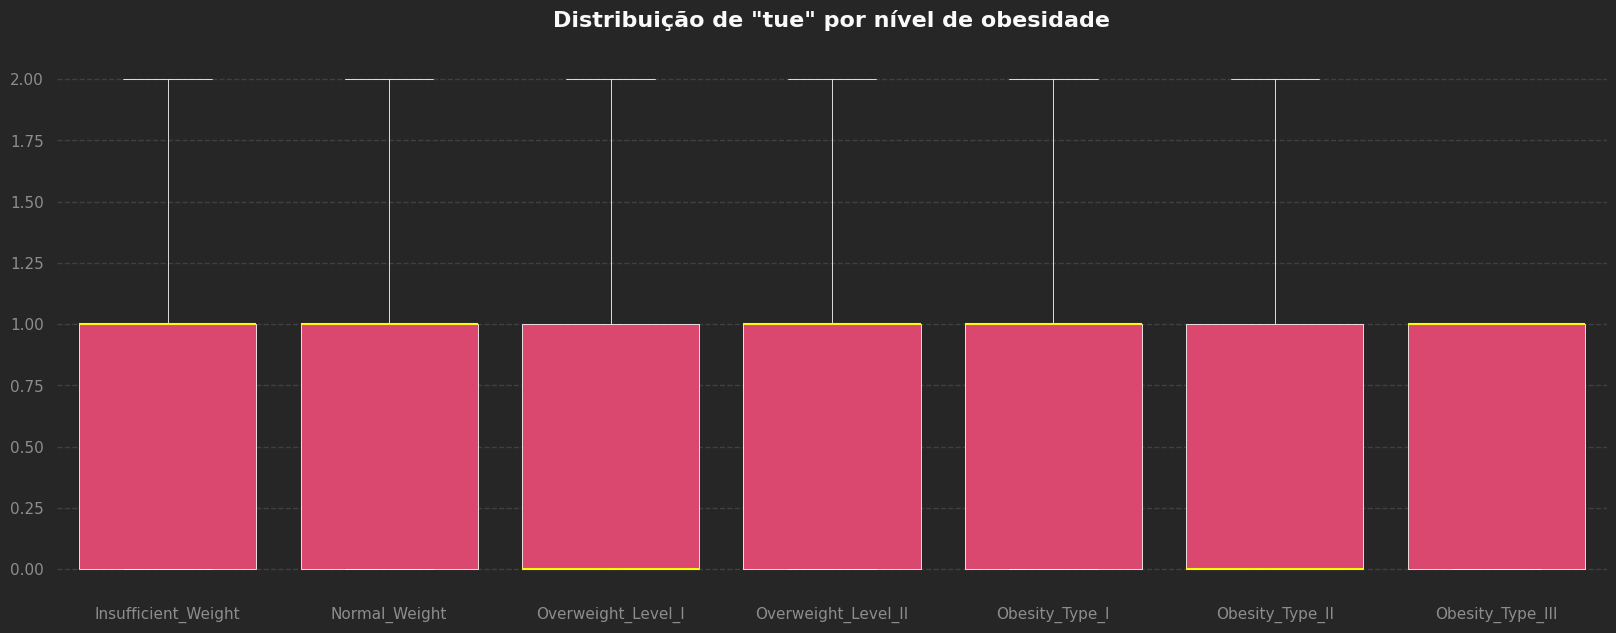

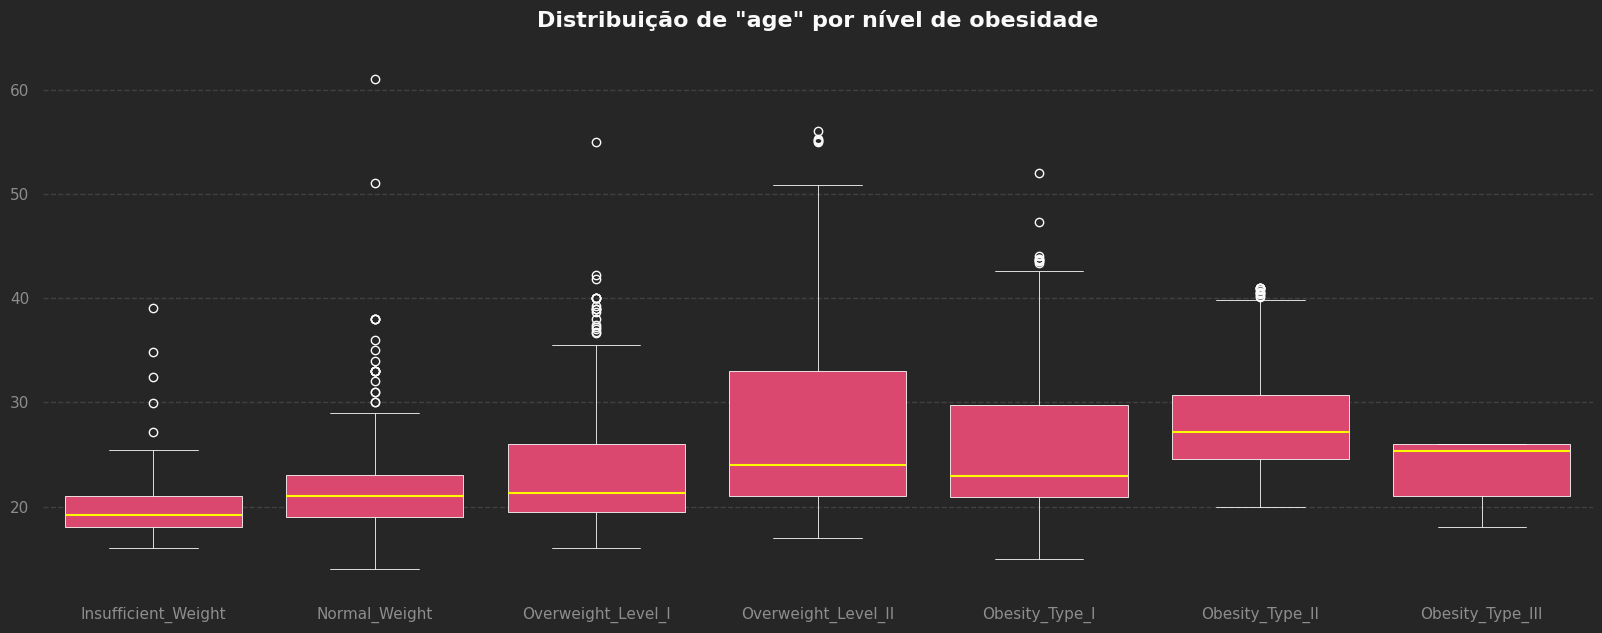

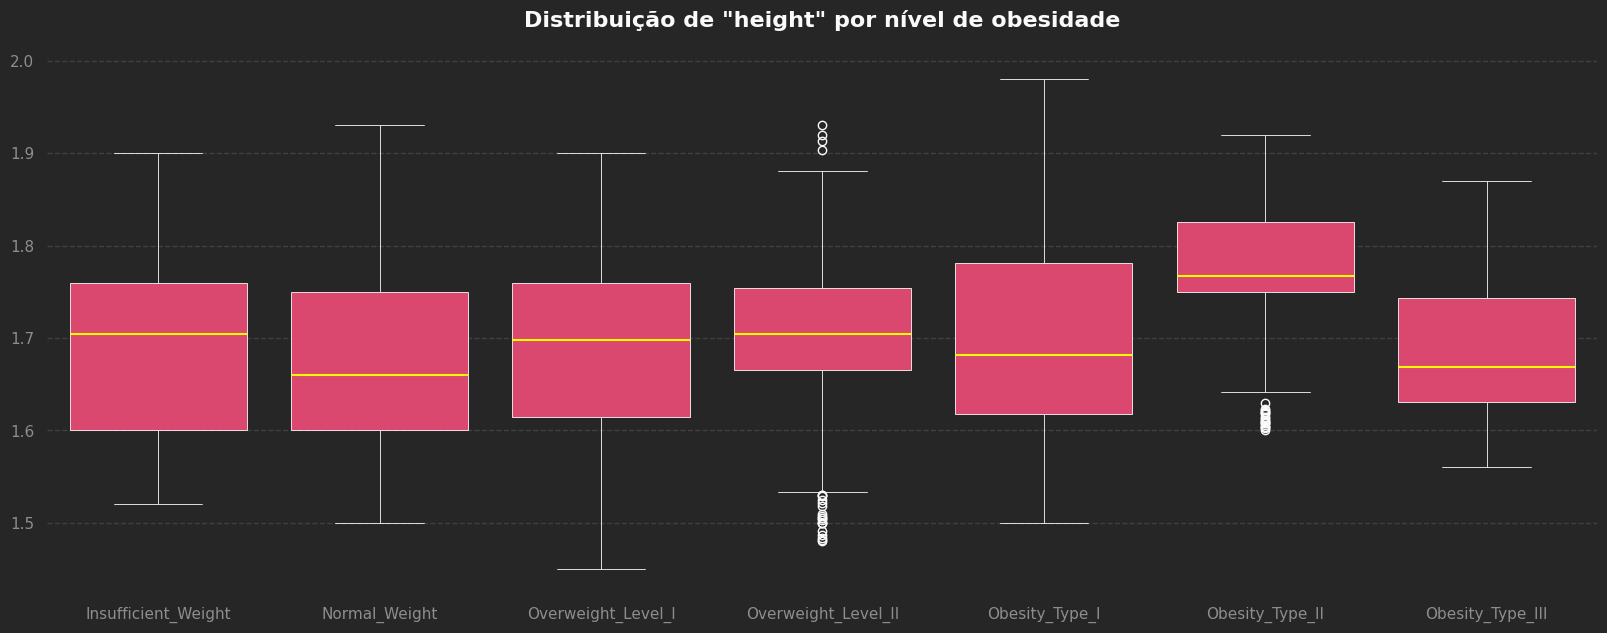

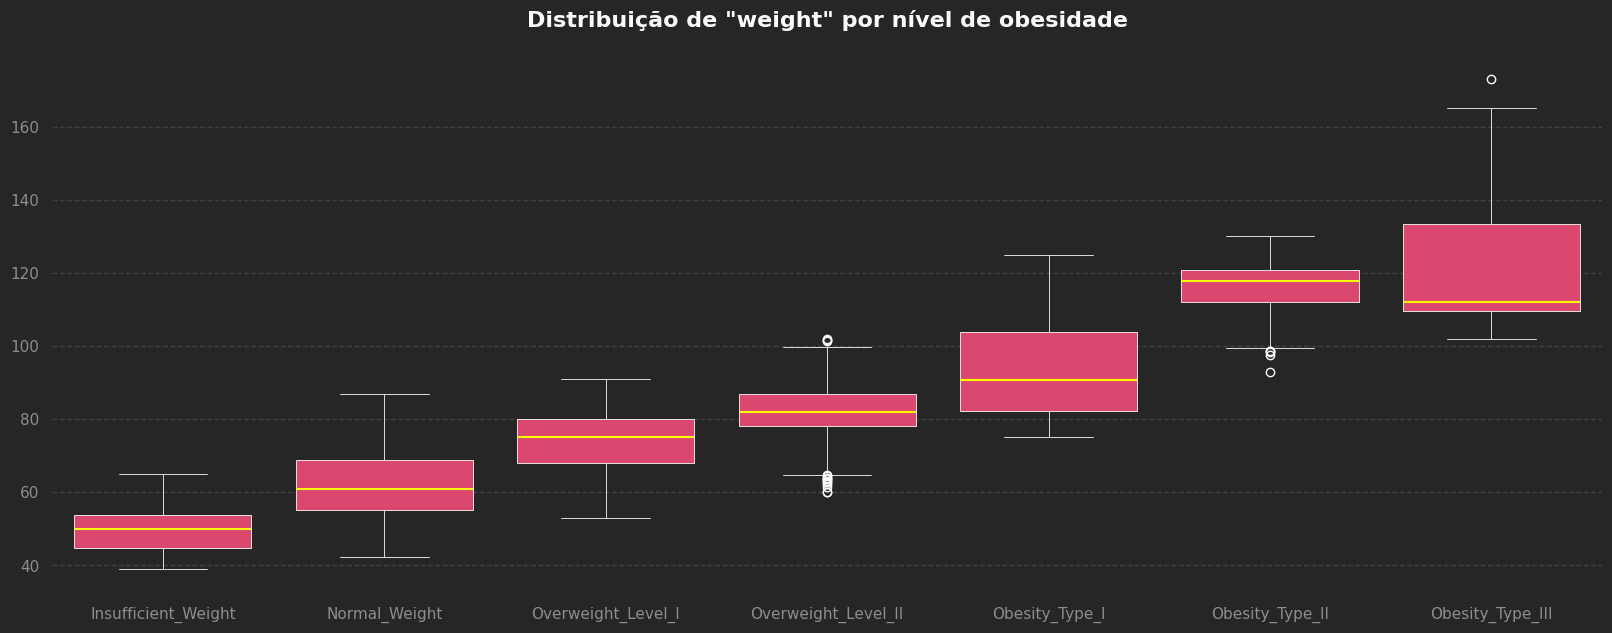

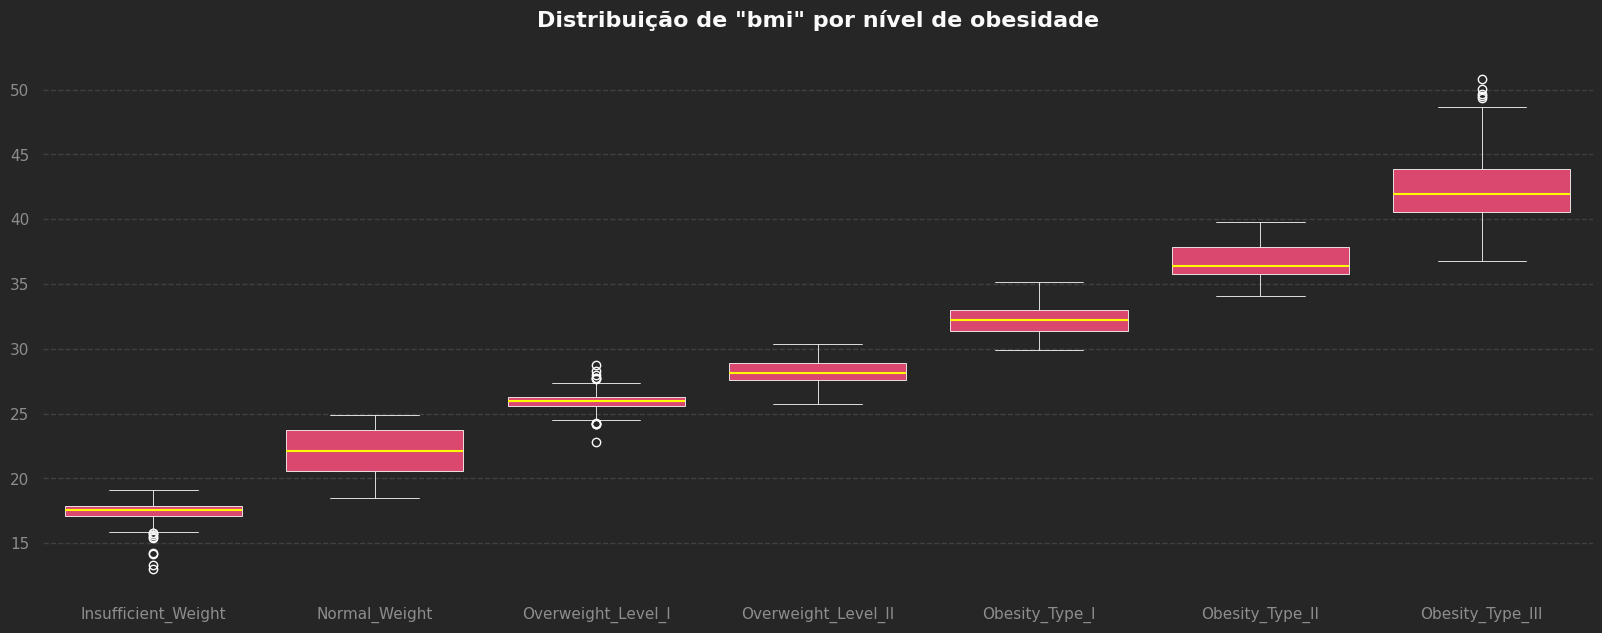

In [ ]:
# gráfico de caixa de variáveis numéricas contra o alvo
for feature in numeric_features:
    sns.boxplot(
        x=target_column,
        y=feature,
        data=df,
        order=target_order,
        linecolor=custom_palette["text"],
        linewidth=0.6,
        medianprops={"color": custom_palette["tertiary"], "linewidth": 1.5},
    )
    plt.title(f'Distribuição de "{feature}" por nível de obesidade')
    sns.despine(bottom=True, left=True)
    plt.xlabel("")
    plt.ylabel("")
    plt.show()

- A mediana da frequência de atividade física (FAF) cai bastante em pessoas com obesidade grau 3, em relação aos outros níveis de peso.
- Há vários outliers para baixo no número de refeições principais tanto para quem está abaixo do peso quanto para quem está com obesidade grau 2. Ou seja, tem um grupo de pessoas que comem muito poucas vezes ao dia (o que pode implicar refeições maiores e mais calóricas para quem está acima do peso).

Como os dados tem outliers importantes, melhor usar o StandardScaler.


## Teste de hipótese


### Qualitativa


O **teste Qui-Quadrado** é uma técnica estatística utilizada para avaliar a associação entre duas variáveis categóricas em uma tabela de contingência. Ele pode ser utilizado para testar a hipótese de que não há relação entre as duas variáveis ou para identificar se uma variável afeta a outra.

- Hipótese Nula ($H_0$): As duas variáveis são independentes.
- Hipótese Alternativa ($H_1$): As duas variáveis são dependentes.


In [ ]:
# Nível de significância
alpha = 0.05
chi2_results = {}

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df[target_column])

    chi2_stat, p_value, dof, expected_freqs = chi2_contingency(contingency_table)

    significance = (
        "Dependente (Rejeita H0)" if p_value < alpha else "Independente (Aceita H0)"
    )
    chi2_results[feature] = {
        "Qui-quadrado": chi2_stat,
        "p-valor": p_value,
        "Graus de liberdade": dof,
        "Resultado": significance,
    }

In [ ]:
for feature, result in chi2_results.items():
    print(f"\n--- Variável: {feature} ---")
    for key, value in result.items():
        print(f"{key}: {value:.6f}" if isinstance(value, float) else f"{key}: {value}")


--- Variável: gender ---
Qui-quadrado: 657.452978
p-valor: 0.000000
Graus de liberdade: 6
Resultado: Dependente (Rejeita H0)

--- Variável: family_history ---
Qui-quadrado: 617.710993
p-valor: 0.000000
Graus de liberdade: 6
Resultado: Dependente (Rejeita H0)

--- Variável: favc ---
Qui-quadrado: 231.276208
p-valor: 0.000000
Graus de liberdade: 6
Resultado: Dependente (Rejeita H0)

--- Variável: mtrans ---
Qui-quadrado: 288.567857
p-valor: 0.000000
Graus de liberdade: 24
Resultado: Dependente (Rejeita H0)

--- Variável: smoke ---
Qui-quadrado: 31.854720
p-valor: 0.000017
Graus de liberdade: 6
Resultado: Dependente (Rejeita H0)

--- Variável: scc ---
Qui-quadrado: 128.030882
p-valor: 0.000000
Graus de liberdade: 6
Resultado: Dependente (Rejeita H0)

--- Variável: caec ---
Qui-quadrado: 723.339781
p-valor: 0.000000
Graus de liberdade: 18
Resultado: Dependente (Rejeita H0)

--- Variável: calc ---
Qui-quadrado: 335.564929
p-valor: 0.000000
Graus de liberdade: 18
Resultado: Dependente (Reje

Todas as variáveis qualitativas são comprovadamente preditores altamente significantes para a classificação da obesidade.


### Quantitativa


O teste **ANOVA** (Análise de Variância) é uma ferramenta estatística utilizada para comparar as médias de três ou mais grupos independentes. No nosso caso, obesidade tem 7 grupos.

- Hipótese Nula ($H_0$): As médias da variável numérica são iguais em todos os grupos de obesidade. (A feature não é um bom preditor).
- Hipótese Alternativa ($H_1$): Pelo menos uma das médias é diferente das outras. (A feature é um bom preditor).


In [ ]:
# Nível de significância
alpha = 0.05

# Loop por todas as colunas numéricas
for feature in numeric_features:
    groups = [
        df[feature][df[target_column] == category]
        for category in df[target_column].unique()
    ]

    f_stat, p_value = f_oneway(*groups)

    print(f"\n--- Variável: {feature} ---")
    print(f"Estatística F: {f_stat:.4f}")
    print(f"P-valor: {p_value:.8f}")

    if p_value < alpha:
        print(
            f"Significante! (p < {alpha}). A média de '{feature}' é estatisticamente diferente entre os grupos de obesidade."
        )
    else:
        print(
            f"Não Significante (p >= {alpha}). Não há evidência de que a média de '{feature}' varie entre os grupos."
        )


--- Variável: fcvc ---
Estatística F: 89.2722
P-valor: 0.00000000
Significante! (p < 0.05). A média de 'fcvc' é estatisticamente diferente entre os grupos de obesidade.

--- Variável: ncp ---
Estatística F: 25.2873
P-valor: 0.00000000
Significante! (p < 0.05). A média de 'ncp' é estatisticamente diferente entre os grupos de obesidade.

--- Variável: ch2o ---
Estatística F: 16.8964
P-valor: 0.00000000
Significante! (p < 0.05). A média de 'ch2o' é estatisticamente diferente entre os grupos de obesidade.

--- Variável: faf ---
Estatística F: 17.8064
P-valor: 0.00000000
Significante! (p < 0.05). A média de 'faf' é estatisticamente diferente entre os grupos de obesidade.

--- Variável: tue ---
Estatística F: 7.4938
P-valor: 0.00000006
Significante! (p < 0.05). A média de 'tue' é estatisticamente diferente entre os grupos de obesidade.

--- Variável: age ---
Estatística F: 76.1954
P-valor: 0.00000000
Significante! (p < 0.05). A média de 'age' é estatisticamente diferente entre os grupos de 

Todas as variáveis quantitativas são comprovadamente preditores altamente significantes para a classificação da obesidade. Contudo, devemos levar em consideração a existência de multicolinearidade que encontramos na correlação.


## Pré-processamento dos dados


In [ ]:
# definindo variáveis preditoras e variável alvo
y = df[target_column]
X = df.drop(columns=[target_column])

In [ ]:
# divisão entre treino (80%) e teste (20%) de forma aleatória e estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed, stratify=y
)

In [ ]:
print(f"Dados divididos: {len(X_train)} treino, {len(X_test)} teste.")

Dados divididos: 1669 treino, 418 teste.


In [ ]:
# Pipeline para variáveis numéricas
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# Pipeline para variáveis categóricas NOMINAIS
nominal_transformer = Pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(
                handle_unknown="ignore",  # Ignora categorias não vistas no treino
                sparse_output=False,  # Retorna um array denso
            ),
        )
    ]
)

# Pipeline para variáveis categóricas ORDINAIS
ordinal_transformer = Pipeline(
    steps=[
        (
            "ordinal",
            OrdinalEncoder(
                categories=[ordinal_variables_order, ordinal_variables_order]
            ),
        )
    ]
)

In [ ]:
# Combinando todos os pipelines em um pré-processador
processor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("nom", nominal_transformer, nominal_features),
        ("ord", ordinal_transformer, ordinal_features),
    ],
    remainder="drop",  # Descarta colunas não listadas
)

In [ ]:
# Pipeline para variável alvo
target_encoder = LabelEncoder()

In [ ]:
# processando os dados de treino
X_train_processed = processor.fit_transform(X_train)
y_train_processed = target_encoder.fit_transform(y_train)

# processando os dados de teste
X_test_processed = processor.transform(X_test)
y_test_processed = target_encoder.transform(y_test)

In [ ]:
print(f"Shape de X_train processado: {X_train_processed.shape}")
print(f"Shape de X_test processado: {X_test_processed.shape}")

Shape de X_train processado: (1669, 26)
Shape de X_test processado: (418, 26)


In [ ]:
# quais classes da variável alvo foram mapeadas para quais números
label_mapping = dict(
    zip(
        np.asarray(target_encoder.classes_),
        np.asarray(target_encoder.transform(target_encoder.classes_)),
        strict=True,
    )
)

label_mapping

{'Insufficient_Weight': np.int64(0),
 'Normal_Weight': np.int64(1),
 'Obesity_Type_I': np.int64(2),
 'Obesity_Type_II': np.int64(3),
 'Obesity_Type_III': np.int64(4),
 'Overweight_Level_I': np.int64(5),
 'Overweight_Level_II': np.int64(6)}

In [ ]:
# exibindo os dados processados em um DataFrame
feature_names = np.asarray(processor.get_feature_names_out())

X_train_processed_df = pd.DataFrame(
    np.asarray(X_train_processed), columns=feature_names, index=X_train.index
)
X_train_processed_df.head()

,num__fcvc,num__ncp,num__ch2o,num__faf,num__tue,num__age,num__height,num__weight,num__bmi,nom__gender_Female,...,nom__mtrans_Bike,nom__mtrans_Motorbike,nom__mtrans_Public_Transportation,nom__mtrans_Walking,nom__smoke_no,nom__smoke_yes,nom__scc_no,nom__scc_yes,ord__caec,ord__calc
1549,-0.740622,0.371111,-0.006123,-0.008128,-1.001278,0.248290,0.705537,1.045026,0.844904,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1574,0.980963,-0.885248,-1.466132,1.122373,0.485495,1.008501,-0.608067,0.505277,0.898149,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1155,0.980963,0.371111,-1.466132,-1.138629,-1.001278,3.702329,0.457500,-0.078269,-0.239464,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
610,-0.740622,0.371111,-0.006123,1.122373,0.485495,-0.208354,0.416482,-1.265285,-1.504390,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0
906,-0.740622,0.371111,1.453885,-0.008128,-1.001278,-0.523216,-1.012212,-0.725998,-0.440226,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


## Treinamento do modelo


In [ ]:
# ajuste de hiperparâmetros para validação cruzada
logistic_regression_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "solver": ["lbfgs"],
    "max_iter": [1000],
}

random_forest_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5],
}

xgboost_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 7],
    "objective": ["multi:softmax"],
    "num_class": [7],
}

In [ ]:
models_to_try = [
    {
        "name": "LogisticRegression",  # Baseline
        "model": LogisticRegression(random_state=seed),
        "grid": logistic_regression_grid,
    },
    {
        "name": "RandomForest",
        "model": RandomForestClassifier(random_state=seed),
        "grid": random_forest_grid,
    },
    {
        "name": "XGBoost",
        "model": XGBClassifier(random_state=seed),
        "grid": xgboost_grid,
    },
]

### Modelo com IMC


In [ ]:
# Buscando melhores parâmetros
for model_info in tqdm(models_to_try, desc="Buscando Melhores Modelos", unit="modelo"):
    model_name = model_info["name"]
    tqdm.write(f"\n--- Treinando: {model_name} ---")

    # Configura o GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["grid"],
        cv=grid_search_cv_folds,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0,
    )

    # Treina
    grid_search.fit(X_train_processed, y_train_processed)

    # Loga os resultados do modelo
    tqdm.write(
        f"Melhor pontuação (Acurácia CV) para {model_name}: "
        f"{grid_search.best_score_:.4f}"
    )
    tqdm.write(f"Melhores parâmetros: {grid_search.best_params_}")

Buscando Melhores Modelos:   0%|          | 0/3 [00:00<?, ?modelo/s]


--- Treinando: LogisticRegression ---


Buscando Melhores Modelos:  33%|███▎      | 1/3 [00:01<00:03,  1.88s/modelo]

Melhor pontuação (Acurácia CV) para LogisticRegression: 0.9497
Melhores parâmetros: {'C': 10.0, 'max_iter': 1000, 'solver': 'lbfgs'}

--- Treinando: RandomForest ---


Buscando Melhores Modelos:  67%|██████▋   | 2/3 [00:06<00:03,  3.22s/modelo]

Melhor pontuação (Acurácia CV) para RandomForest: 0.9856
Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Treinando: XGBoost ---


Buscando Melhores Modelos: 100%|██████████| 3/3 [00:09<00:00,  3.24s/modelo]

Melhor pontuação (Acurácia CV) para XGBoost: 0.9820
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'num_class': 7, 'objective': 'multi:softmax'}


Uma acurácia de quase 99% é um sinal de alerta. Resultados "perfeitos" em dados do mundo real quase nunca existem. Quando eles aparecem, geralmente significam que algo está errado.

No nosso caso, isso foi provavelmente causado pela multicolinariedade entre IMC e peso. É possível que o modelo não esteja prevendo a obesidade, mas, sim, calculando a obesidade. Basicamente, o modelo aprendeu a fórmula exata do IMC e os pontos de corte que definem as classes de obesidade.


### Modelo sem IMC


> Baseado no histórico e estilo de vida de um paciente, qual é o risco dele desenvolver obesidade?

Para responder a essa pergunta, temos que remover as consequências (peso, altura e IMC) e focar nas causas (estilo de vida, demografia).

O objetivo da ferramenta não é diagnosticar (o médico já faz isso com IMC), mas sim aconselhar e prevenir, mostrando quais fatores de risco (dieta, exercício, etc.) são mais impactantes para aquele paciente.


In [ ]:
# definindo variáveis preditoras e variável alvo
y = df[target_column]
X = df.drop(columns=[target_column, "height", "weight", "bmi"])

# divisão entre treino (80%) e teste (20%) de forma aleatória e estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed, stratify=y
)

In [ ]:
# sem colunas height, weight, bmi
numeric_features_without_bmi = ["age", "fcvc", "ncp", "ch2o", "faf", "tue"]

In [ ]:
# combinando todos os pipelines em um pré-processador
processor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_without_bmi),
        ("nom", nominal_transformer, nominal_features),
        ("ord", ordinal_transformer, ordinal_features),
    ],
    remainder="drop",  # descarta colunas não listadas
)

# processando os dados de treino
X_train_processed = processor.fit_transform(X_train)
y_train_processed = target_encoder.fit_transform(y_train)

# processando os dados de teste
X_test_processed = processor.transform(X_test)
y_test_processed = target_encoder.transform(y_test)

print(f"Shape de X_train processado: {X_train_processed.shape}")
print(f"Shape de X_test processado: {X_test_processed.shape}")

Shape de X_train processado: (1669, 23)
Shape de X_test processado: (418, 23)


In [ ]:
best_model = None
best_model_name = ""
best_model_score = -1.0

In [ ]:
# Buscando melhores parâmetros
for model_info in tqdm(models_to_try, desc="Buscando Melhores Modelos", unit="modelo"):
    model_name = model_info["name"]
    tqdm.write(f"\n--- Treinando: {model_name} ---")

    # Configura o GridSearchCV
    grid_search = GridSearchCV(
        estimator=model_info["model"],
        param_grid=model_info["grid"],
        cv=grid_search_cv_folds,
        scoring="accuracy",
        n_jobs=-1,
        verbose=0,
    )

    # Treina
    grid_search.fit(X_train_processed, y_train_processed)

    # Loga os resultados do modelo
    tqdm.write(
        f"Melhor pontuação (Acurácia CV) para {model_name}: "
        f"{grid_search.best_score_:.4f}"
    )
    tqdm.write(f"Melhores parâmetros: {grid_search.best_params_}")

    # Atualiza o melhor modelo geral
    if grid_search.best_score_ > best_model_score:
        best_model_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        best_model_name = model_name

Buscando Melhores Modelos:   0%|          | 0/3 [00:00<?, ?modelo/s]


--- Treinando: LogisticRegression ---


Buscando Melhores Modelos:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/modelo]

Melhor pontuação (Acurácia CV) para LogisticRegression: 0.5752
Melhores parâmetros: {'C': 10.0, 'max_iter': 1000, 'solver': 'lbfgs'}

--- Treinando: RandomForest ---


Buscando Melhores Modelos:  67%|██████▋   | 2/3 [00:05<00:02,  2.90s/modelo]

Melhor pontuação (Acurácia CV) para RandomForest: 0.8005
Melhores parâmetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Treinando: XGBoost ---


Buscando Melhores Modelos: 100%|██████████| 3/3 [00:08<00:00,  3.00s/modelo]

Melhor pontuação (Acurácia CV) para XGBoost: 0.8089
Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'num_class': 7, 'objective': 'multi:softmax'}


Agora, sim, forçamos o modelo a ser um preditor de risco e não uma calculadora.


In [ ]:
print(f"O melhor modelo foi {best_model_name}")

O melhor modelo foi XGBoost


## Avaliação do modelo


In [ ]:
# Fazendo previsão com dados de teste
y_pred = best_model.predict(X_test_processed)
y_pred_proba = best_model.predict_proba(X_test_processed)

In [ ]:
# Calculando acurácia para conferir se atingimos o objetivo
test_accuracy = accuracy_score(y_test_processed, y_pred)

if test_accuracy >= 0.75:
    print(f"Meta atingida! Acurácia ({test_accuracy:.4f}) >= 75%")
else:
    print(f"Meta NÃO atingida. Acurácia ({test_accuracy:.4f}) < 75%")

Meta atingida! Acurácia (0.7847) >= 75%


In [ ]:
# Relatório de classificação
class_report = classification_report(
    y_test_processed, y_pred, target_names=target_encoder.classes_
)

print("Relatório de Classificação:\n")
print(class_report)

Relatório de Classificação:

                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.83      0.82        53
      Normal_Weight       0.62      0.61      0.62        57
     Obesity_Type_I       0.72      0.80      0.76        70
    Obesity_Type_II       0.85      0.95      0.90        60
   Obesity_Type_III       0.97      0.98      0.98        65
 Overweight_Level_I       0.66      0.67      0.67        55
Overweight_Level_II       0.85      0.60      0.71        58

           accuracy                           0.78       418
          macro avg       0.78      0.78      0.78       418
       weighted avg       0.79      0.78      0.78       418



In [ ]:
# Pontuação da curva ROC (quanto mais próximo de 1, melhor)
auc_score_val = roc_auc_score(
    y_test_processed, y_pred_proba, multi_class="ovr", average="macro"
)

print(f"Macro-Average ROC AUC (OvR): {auc_score_val}")

Macro-Average ROC AUC (OvR): 0.9577063747974421


In [ ]:
# Matriz de confusão
conf_matrix = confusion_matrix(y_test_processed, y_pred)
conf_matrix

array([[44,  4,  3,  0,  0,  1,  1],
       [ 8, 35,  5,  1,  0,  6,  2],
       [ 0,  5, 56,  3,  1,  4,  1],
       [ 0,  1,  0, 57,  0,  2,  0],
       [ 0,  1,  0,  0, 64,  0,  0],
       [ 1,  7,  7,  1,  0, 37,  2],
       [ 1,  3,  7,  5,  1,  6, 35]])

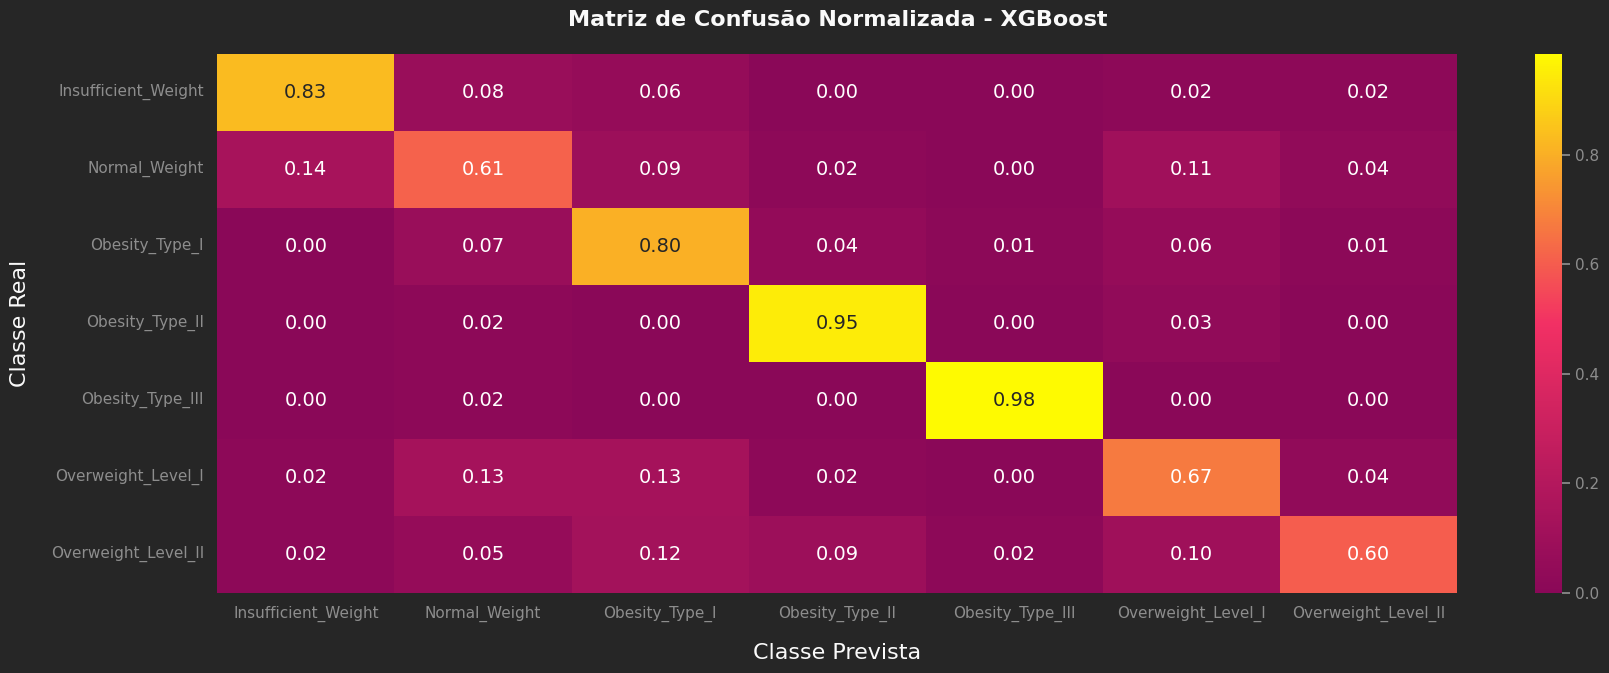

In [ ]:
# Rótulo para melhorar visualização do mapa de calor
inv_label_mapping = {v: k for k, v in label_mapping.items()}
labels = [inv_label_mapping[i] for i in range(len(inv_label_mapping))]

# Normalizar a matriz para ver a porcentagem de acertos
conf_matrix_norm = confusion_matrix(y_test_processed, y_pred, normalize="true")

sns.heatmap(
    conf_matrix_norm,
    annot=True,
    fmt=".2f",
    xticklabels=labels,
    yticklabels=labels,
    cmap=custom_cmap,
)
plt.title(f"Matriz de Confusão Normalizada - {best_model_name}")
plt.ylabel("Classe Real")
plt.xlabel("Classe Prevista")
plt.show()

O modelo prevê muito bem os graus II e III de obesidade, bem como pessoas abaixo do peso. Porém, tem mais dificuldades de prever pessoas com peso normal e sobrepeso de grau I.


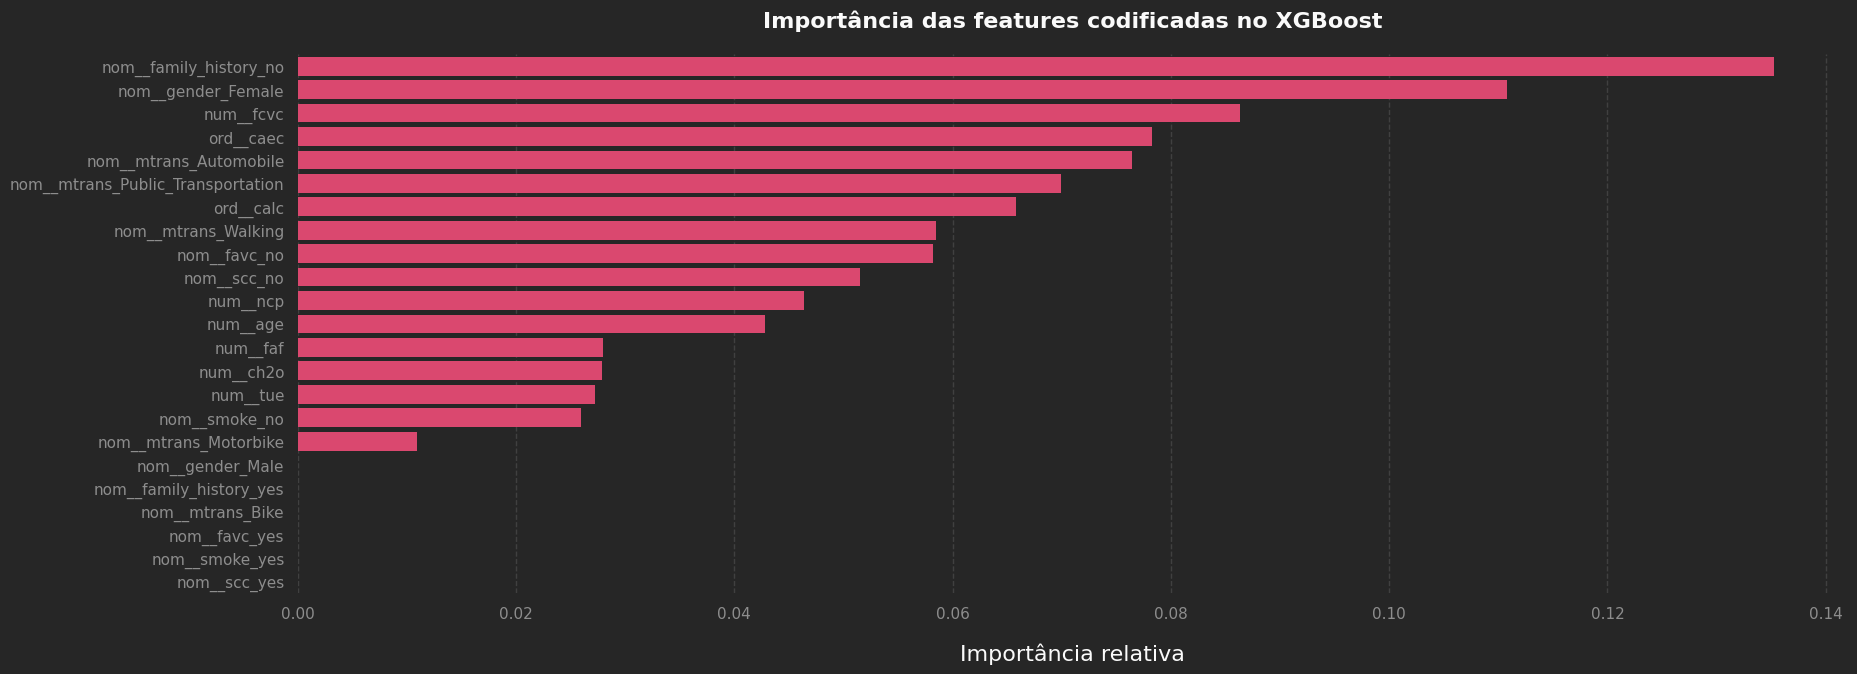

In [ ]:
# Importância das features
feature_names = np.asarray(processor.get_feature_names_out())

if hasattr(best_model, "feature_importances_"):
    feature_importances = (
        pd.Series(best_model.feature_importances_, index=feature_names)
        .sort_values(ascending=False)
        .reset_index(name="importance")
    )

    # plotando as features em ordem de importância para a previsão do modelo
    sns.barplot(data=feature_importances, x="importance", y="index")
    plt.title(f"Importância das features codificadas no {best_model_name}")
    plt.ylabel("")
    plt.xlabel("Importância relativa")
    plt.show()

In [ ]:
# Importância por feature original
feature_importances["original_feature"] = (
    feature_importances["index"].str.split("__").str[-1].str.split("_").str[0]
)
agg_importance = (
    feature_importances.groupby("original_feature")["importance"]
    .sum()
    .sort_values(ascending=False)
)
agg_importance

original_feature
mtrans    0.215780
family    0.135268
gender    0.110767
fcvc      0.086349
caec      0.078228
calc      0.065779
favc      0.058244
scc       0.051492
ncp       0.046356
age       0.042800
faf       0.027936
ch2o      0.027832
tue       0.027239
smoke     0.025930
Name: importance, dtype: float32